In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import json
import re
from functools import partial
from io import StringIO
from itertools import combinations
from pathlib import Path

from scipy import stats
from sklearn.metrics import mean_squared_error
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from QligFEP.analyze_FEP import FepReader
from scipy.stats import kendalltau
from sklearn.metrics import mean_absolute_error
import networkx as nx
from typing import Literal, Union
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mcolors

In [3]:
from rdkit import Chem
from openff.toolkit import Molecule
from QligFEP.chemIO import MoleculeIO
from QligFEP.CLI.utils import get_avail_restraint_methods
from QligFEP.restraints.restraint_setter import RestraintSetter
from pyfonts import load_google_font

tick_font = load_google_font("Montserrat", weight=500)
label_font = load_google_font("Montserrat", weight=500, italic=True)
title_font = load_google_font("Montserrat", weight=500)


def set_font_properties(ax, tick_font=tick_font, label_font=label_font, title_font=title_font):
    ax.set_xlabel(ax.get_xlabel(), fontproperties=label_font, size=12)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=label_font, size=12)
    ax.set_title(ax.get_title(), fontproperties=title_font, size=14)
    for label in ax.get_xticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    legend = ax.get_legend()
    if legend:
        # Update the font properties of the legend texts
        for text in legend.get_texts():
            text.set_fontproperties(label_font)
        # Optionally, update the font of the legend title if it exists
        if legend.get_title():
            legend.get_title().set_fontproperties(title_font)


def calculate_restraint_similarity(
    ligand1: Union[Molecule, Chem.Mol, str, Path],
    ligand2: Union[Molecule, Chem.Mol, str, Path],
    restraint_method: str = "hybridization_p",
) -> dict[int, int]:
    """Apply the restraints according to the specified method and calculate several similarity
    scores between them.

    Args:
        ligand1: First ligand (RDKit Mol or custom Molecule object).
        ligand2: Second ligand (RDKit Mol or custom Molecule object).
        restraint_method: Chosen method for setting the ligand restraints. Defaults to "hybridization_p".

    Returns: # TODO
        The similarity score between the two ligands, calculated as the squared number of restrained atoms
        divided by the product of the number of atoms in each ligand.
    """
    ligand1 = RestraintSetter.input_to_small_molecule_component(ligand1)
    ligand2 = RestraintSetter.input_to_small_molecule_component(ligand2)

    # Handle cases where a custom kartograf threshold is provided
    kartograf_thresh = 0.95
    if len(restraint_method.split("_")) == 3:
        kartograf_thresh = float(restraint_method.split("_")[2])
        restraint_method = "_".join(restraint_method.split("_")[:2])
        pass
    elif len(restraint_method.split("_")) > 3:
        raise ValueError(
            f"restraint_method should be of the form `method_permissiveness_krtgrfThresh`, got {restraint_method}"
        )

    # Check if the passed restraint method is available
    if restraint_method not in get_avail_restraint_methods():
        raise ValueError(
            f"restraint_method should be one of {get_avail_restraint_methods()}, got {restraint_method}"
        )
    elif restraint_method == "overlap":
        raise ValueError("Overlap method is not supported by this method yet, use `kartograf` instead.")
    rsetter = RestraintSetter(ligand1, ligand2, kartograf_thresh)

    # Set the restraints according to the chosen method
    if restraint_method == "kartograf":
        restraint_dict = rsetter.set_restraints(
            kartograf_native=True,  # other arguments ignored
        )
    else:
        atom_compare_method, permissiveness_lvl = restraint_method.split("_")
        if permissiveness_lvl == "p":
            # in this case, ignore_surround_atom_type is not needed
            params = {"strict_surround": False}
        elif permissiveness_lvl == "ls":
            params = {"strict_surround": True, "ignore_surround_atom_type": True}
        elif permissiveness_lvl == "strict":
            params = {"strict_surround": True, "ignore_surround_atom_type": False}
        restraint_dict = rsetter.set_restraints(atom_compare_method=atom_compare_method, **params)
        # logger.debug(f"Restraints set using {restraint_method} method. Parameters: {params}")

    # Calculate some metrics on the differences between the ligands: can we estimate the error?
    n_restrained = len(restraint_dict.keys())
    natoms_lig1 = ligand1.to_rdkit().GetNumHeavyAtoms()
    natoms_lig2 = ligand2.to_rdkit().GetNumHeavyAtoms()
    similarity = n_restrained**2 / (natoms_lig1 * natoms_lig2)
    atom_n_diff = abs(natoms_lig1 - natoms_lig2)
    unrestrained_bigger_mol = max(natoms_lig1, natoms_lig2) - n_restrained

    nRingsA = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand1.to_rdkit()))
    nRingsB = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand2.to_rdkit()))
    diff_rings = abs(nRingsA - nRingsB)
    return similarity, atom_n_diff, unrestrained_bigger_mol, diff_rings

In [4]:
all_dataframes = []

# JACS

## bace

2025-09-12 15:25:11 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.37_{0.17}^{0.54}$ RMSE = $1.70_{1.32}^{2.05}  \frac{kcal}{mol}$ MUE = $1.28_{0.99}^{1.6}  \frac{kcal}{mol}$


Crashes:  0


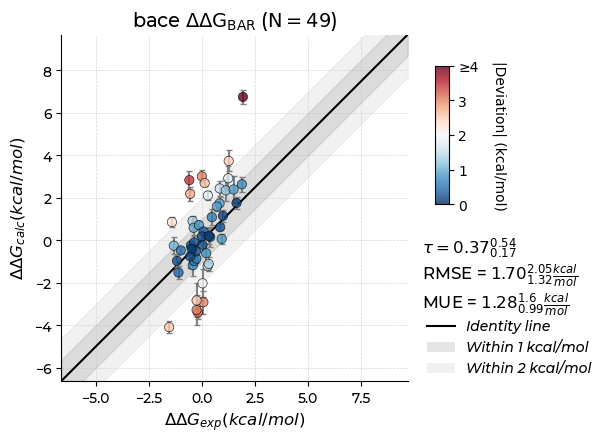

In [5]:
json_results = json.loads(Path("results/bace/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True), target_name="bace", font=tick_font
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/bace_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/bace_regression.svg", bbox_inches="tight", facecolor="white")

In [6]:
fep_names = {}

chemio = MoleculeIO("perturbations/bace/ligands.sdf")
network_dict = json.loads(Path("perturbations/bace/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="bace"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cdk2

2025-09-12 15:25:18 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.52_{0.2}^{0.78}$ RMSE = $1.49_{1.07}^{1.86}  \frac{kcal}{mol}$ MUE = $1.17_{0.83}^{1.54}  \frac{kcal}{mol}$


Crashes:  0


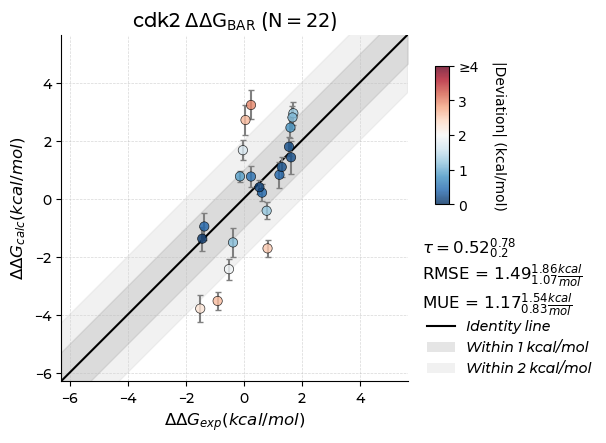

In [7]:
json_results = json.loads(Path("results/cdk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk2",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/cdk2_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/cdk2_regression.svg", bbox_inches="tight", facecolor="white")

In [8]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="cdk2"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:25:19 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiy. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oi9. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 32. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiu. Reindexed.
2025-09-12 15:25:20 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2

## jnk1

2025-09-12 15:25:24 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.35_{0.07}^{0.61}$ RMSE = $0.86_{0.6}^{1.11}  \frac{kcal}{mol}$ MUE = $0.66_{0.47}^{0.88}  \frac{kcal}{mol}$


Crashes:  0


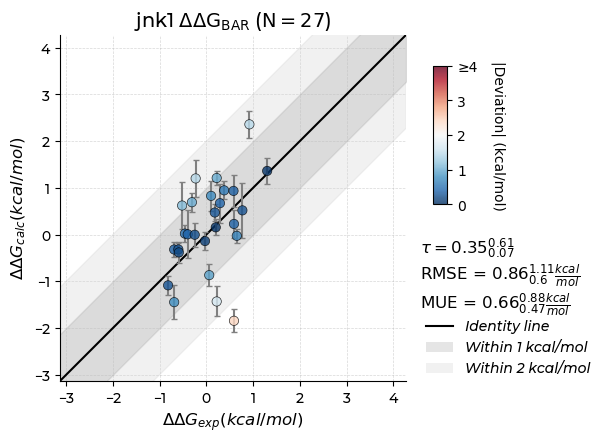

In [9]:
json_results = json.loads(Path("results/jnk1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="jnk1",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/jnk1_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/jnk1_regression.svg", bbox_inches="tight", facecolor="white")

In [10]:
fep_names = {}

chemio = MoleculeIO("perturbations/jnk1/ligands.sdf")
network_dict = json.loads(Path("perturbations/jnk1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="jnk1"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18626-1. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18628-1_flip. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18629-1. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18636-1. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18638-1. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18659-1. Reindexed.
2025-09-12 15:25:25 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of

## mcl1

2025-09-12 15:25:30 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.14_{-0.05}^{0.33}$ RMSE = $2.03_{1.6}^{2.47}  \frac{kcal}{mol}$ MUE = $1.62_{1.31}^{1.94}  \frac{kcal}{mol}$


Crashes:  0


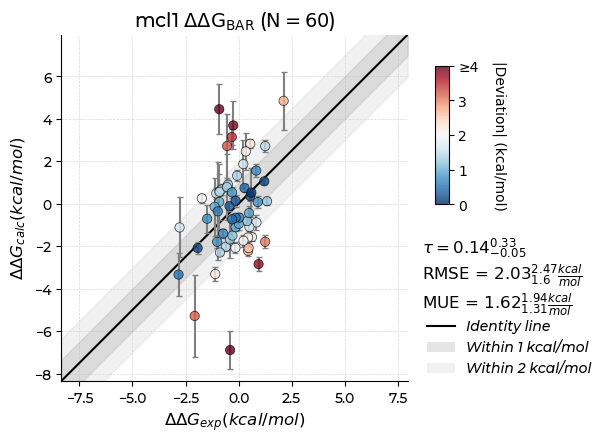

In [11]:
json_results = json.loads(Path("results/mcl1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="mcl1",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/mcl1_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/mcl1_regression.svg", bbox_inches="tight", facecolor="white")

In [12]:
fep_names = {}

chemio = MoleculeIO("perturbations/mcl1/ligands.sdf")
network_dict = json.loads(Path("perturbations/mcl1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="mcl1"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 23. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 26. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 27. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 29. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30_flip. Reindexed.
2025-09-12 15:25:32 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 31

## p38

2025-09-12 15:25:37 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:543 - Dropping FEPs with nan values: ['FEP_2k_2q' 'FEP_2k_2u']
2025-09-12 15:25:40 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.54_{0.42}^{0.64}$ RMSE = $1.49_{1.08}^{1.98}  \frac{kcal}{mol}$ MUE = $1.13_{0.89}^{1.42}  \frac{kcal}{mol}$


Crashes:  2


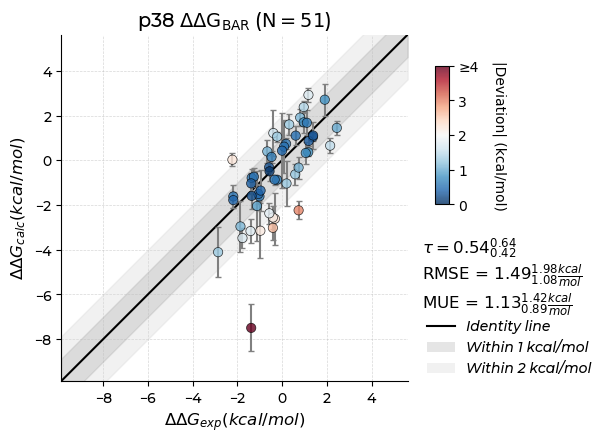

In [13]:
json_results = json.loads(Path("results/p38/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="p38",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/p38_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/p38_regression.svg", bbox_inches="tight", facecolor="white")

In [14]:
fep_names = {}

chemio = MoleculeIO("perturbations/p38/ligands.sdf")
network_dict = json.loads(Path("perturbations/p38/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="p38"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2gg. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2q. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2t. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2l. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2ee. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2aa. Reindexed.
2025-09-12 15:25:42 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2o. 

## ptp1b

2025-09-12 15:25:48 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.34_{0.08}^{0.61}$ RMSE = $2.75_{1.91}^{3.46}  \frac{kcal}{mol}$ MUE = $1.98_{1.37}^{2.71}  \frac{kcal}{mol}$


Crashes:  0


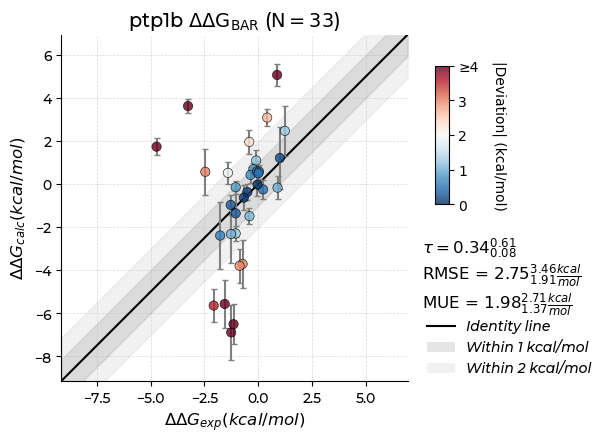

In [15]:
json_results = json.loads(Path("results/ptp1b/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/ptp1b_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/ptp1b_regression.svg", bbox_inches="tight", facecolor="white")

### 2x Sampling

For `ptp1b`, we noticed outliers with very low energies for groups involving large perturbations. Therefore, we decided to run the same perturbation but with doubled sampling for each lambda step. The results we got are below:

2025-09-12 15:25:52 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.39_{0.19}^{0.57}$ RMSE = $1.89_{1.47}^{2.32}  \frac{kcal}{mol}$ MUE = $1.55_{1.19}^{1.96}  \frac{kcal}{mol}$


Crashes:  0


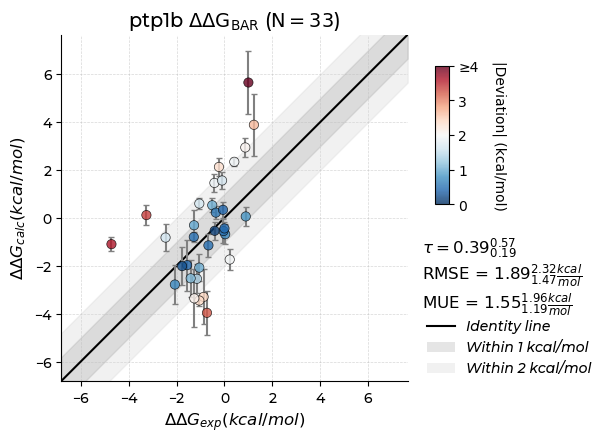

In [16]:
json_results = json.loads(Path("results/ptp1b2xSampled/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/ptp1b2xSampled_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/ptp1b2xSampled_regression.svg", bbox_inches="tight", facecolor="white")

In [17]:
fep_names = {}

chemio = MoleculeIO("perturbations/ptp1b/ligands.sdf")
network_dict = json.loads(Path("perturbations/ptp1b/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="ptp1b"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## thrombin

2025-09-12 15:25:57 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.38_{-0.05}^{0.74}$ RMSE = $1.37_{0.71}^{1.89}  \frac{kcal}{mol}$ MUE = $1.03_{0.61}^{1.57}  \frac{kcal}{mol}$


Crashes:  0


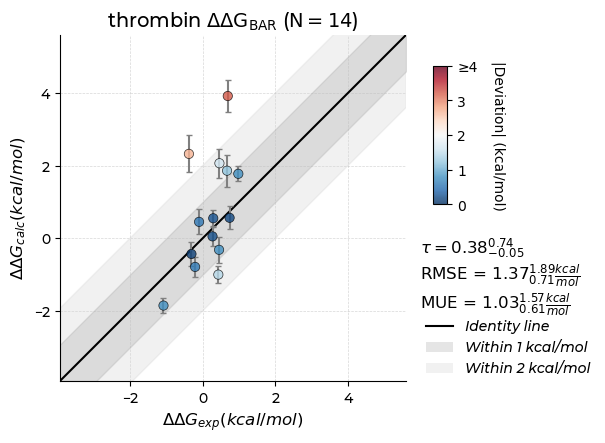

In [18]:
json_results = json.loads(Path("results/thrombin/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="thrombin",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/thrombin_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/thrombin_regression.svg", bbox_inches="tight", facecolor="white")

In [19]:
fep_names = {}

chemio = MoleculeIO("perturbations/thrombin/ligands.sdf")
network_dict = json.loads(Path("perturbations/thrombin/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="thrombin"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6a. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 3a. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1d. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6e. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6b. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-09-12 15:25:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1a. Rei

## tyk2

2025-09-12 15:26:02 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.47_{0.18}^{0.69}$ RMSE = $0.85_{0.66}^{1.04}  \frac{kcal}{mol}$ MUE = $0.74_{0.57}^{0.91}  \frac{kcal}{mol}$


Crashes:  0


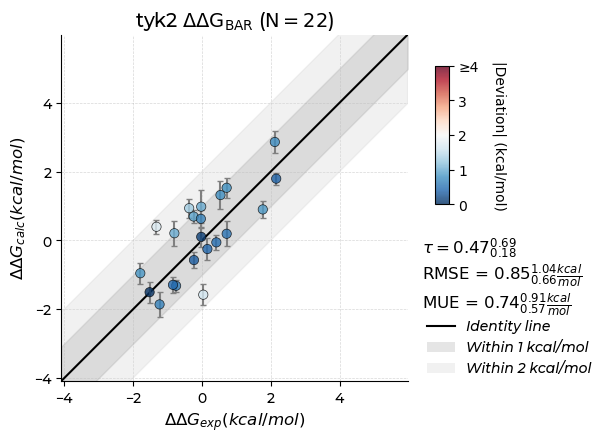

In [20]:
json_results = json.loads(Path("results/tyk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tyk2",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/tyk2_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/tyk2_regression.svg", bbox_inches="tight", facecolor="white")

In [21]:
fep_names = {}

chemio = MoleculeIO("perturbations/tyk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tyk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="tyk2"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule jmc_23. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_47. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_49. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_45. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_44. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_43. Reindexed.
2025-09-12 15:26:03 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom l

# Merck

## cdk8

2025-09-12 15:26:07 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.28_{0.09}^{0.47}$ RMSE = $2.58_{1.96}^{3.21}  \frac{kcal}{mol}$ MUE = $1.94_{1.51}^{2.46}  \frac{kcal}{mol}$


Crashes:  0


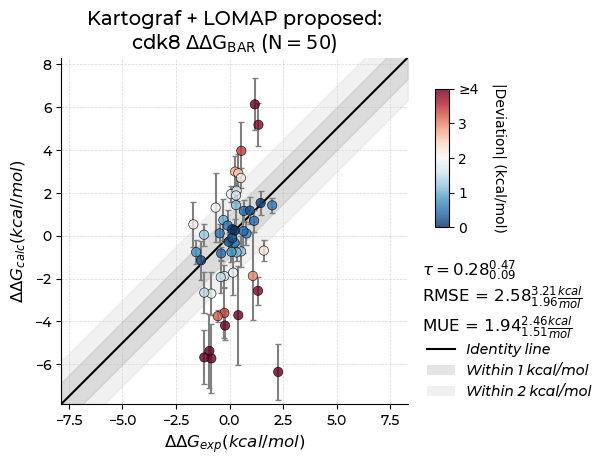

In [22]:
json_results = json.loads(Path("results/cdk8/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
xlabel = ax.get_title()
ax.set_title(f"Kartograf + LOMAP proposed:\n{xlabel}")
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/cdk8_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/cdk8_regression.svg", bbox_inches="tight", facecolor="white")

### Manual Mapping

For `cdk8`, we noticed a lot of the perturbations present in the automated mapping were difficult to accomplish. In this ligand set, two R-groups get perturbed at once, making it more prone for endpoint catastrophes. We decided to manually map the perturbations to avoid this. The results we got are below:

2025-09-12 15:26:11 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.40_{0.22}^{0.56}$ RMSE = $1.99_{1.61}^{2.38}  \frac{kcal}{mol}$ MUE = $1.58_{1.28}^{1.91}  \frac{kcal}{mol}$


Crashes:  0


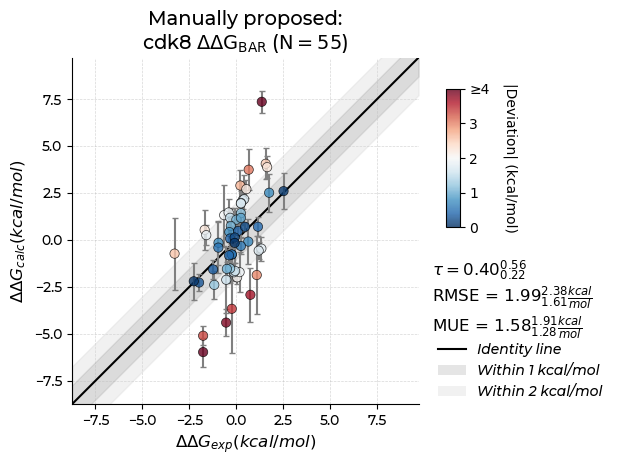

In [23]:
json_results = json.loads(Path("results/cdk8ManualMapping/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
xlabel = ax.get_title()
ax.set_title(f"Manually proposed:\n{xlabel}")
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/cdk8-manual-mapping_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/cdk8-manual-mapping_regression.svg", bbox_inches="tight", facecolor="white")

In [24]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk8/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk8ManualMapping/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="cdk8"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cmet

2025-09-12 15:26:17 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:543 - Dropping FEPs with nan values: ['FEP_CHEMBL3402744_300_CHEMBL3402761_1-redocked']
2025-09-12 15:26:19 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.42_{0.21}^{0.63}$ RMSE = $3.21_{1.51}^{4.81}  \frac{kcal}{mol}$ MUE = $1.86_{1.12}^{2.89}  \frac{kcal}{mol}$


Crashes:  1


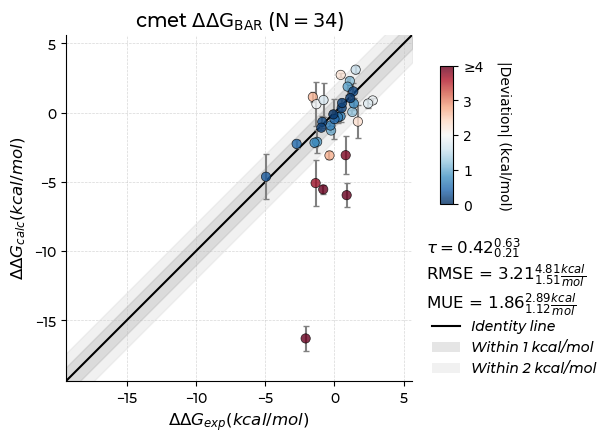

In [25]:
json_results = json.loads(Path("results/cmet/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cmet",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/cmet_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/cmet_regression.svg", bbox_inches="tight", facecolor="white")

In [26]:
fep_names = {}

chemio = MoleculeIO("perturbations/cmet/ligands.sdf")
network_dict = json.loads(Path("perturbations/cmet/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="cmet"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## eg5

2025-09-12 15:26:26 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.24_{0.02}^{0.43}$ RMSE = $2.50_{1.6}^{3.59}  \frac{kcal}{mol}$ MUE = $1.77_{1.29}^{2.4}  \frac{kcal}{mol}$


Crashes:  0


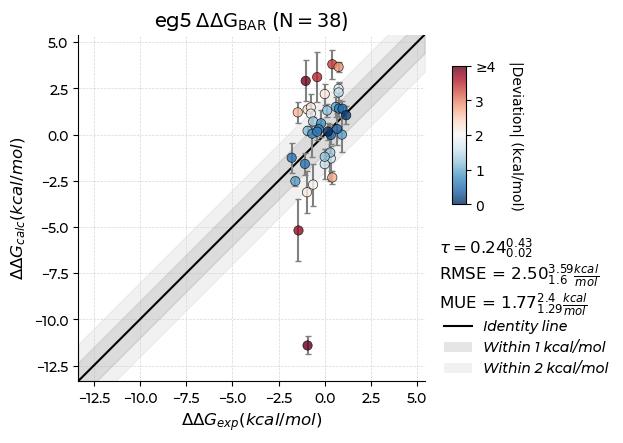

In [27]:
json_results = json.loads(Path("results/eg5/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="eg5",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/eg5_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/eg5_regression.svg", bbox_inches="tight", facecolor="white")

In [28]:
fep_names = {}

chemio = MoleculeIO("perturbations/eg5/ligands.sdf")
network_dict = json.loads(Path("perturbations/eg5/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="eg5"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## hif2a

2025-09-12 15:26:31 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:543 - Dropping FEPs with nan values: ['FEP_1_41' 'FEP_84_41']
2025-09-12 15:26:33 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.30_{0.1}^{0.47}$ RMSE = $2.13_{1.75}^{2.49}  \frac{kcal}{mol}$ MUE = $1.68_{1.36}^{2.02}  \frac{kcal}{mol}$


Crashes:  2


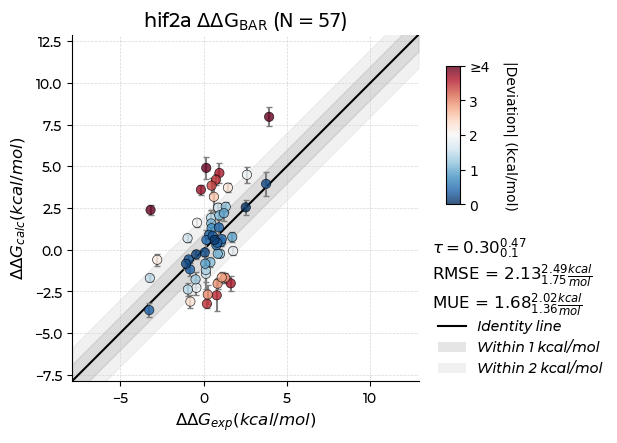

In [29]:
json_results = json.loads(Path("results/hif2a/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="hif2a",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/hif2a_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/hif2a_regression.svg", bbox_inches="tight", facecolor="white")

In [30]:
fep_names = {}

chemio = MoleculeIO("perturbations/hif2a/ligands.sdf")
network_dict = json.loads(Path("perturbations/hif2a/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="hif2a"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## shp2

2025-09-12 15:26:41 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.46_{0.29}^{0.62}$ RMSE = $3.08_{2.18}^{3.78}  \frac{kcal}{mol}$ MUE = $2.34_{1.71}^{3.02}  \frac{kcal}{mol}$


Crashes:  0


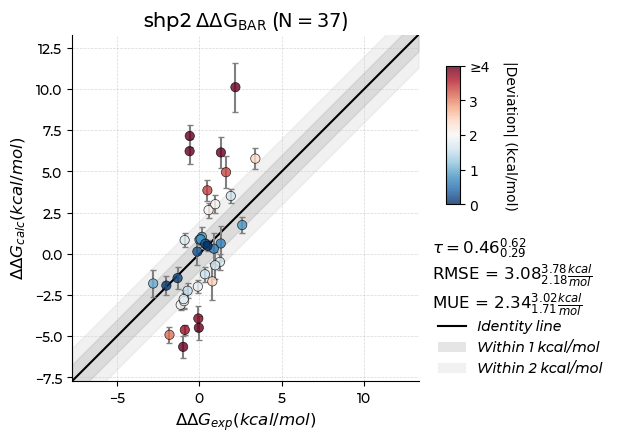

In [31]:
json_results = json.loads(Path("results/shp2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isnull()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="shp2",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isnull().sum())

fig.savefig("figures/shp2_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/shp2_regression.svg", bbox_inches="tight", facecolor="white")

In [32]:
fep_names = {}

chemio = MoleculeIO("perturbations/shp2/ligands.sdf")
network_dict = json.loads(Path("perturbations/shp2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p_1.2"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="shp2"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-22. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 11. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-6. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-9. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-8. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 7. Reindexed.
2025-09-12 15:26:43 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the at

## syk

2025-09-12 15:26:45 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:543 - Dropping FEPs with nan values: ['FEP_CHEMBL3265015-flip_CHEMBL3265011-flip'
 'FEP_CHEMBL3259820_docked-CHEMBL3264999-adjust'
 'FEP_CHEMBL3265020_CHEMBL3265018' 'FEP_CHEMBL3265006_CHEMBL3265011-flip']
2025-09-12 15:26:48 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.42_{0.25}^{0.56}$ RMSE = $1.40_{1.12}^{1.76}  \frac{kcal}{mol}$ MUE = $1.09_{0.87}^{1.33}  \frac{kcal}{mol}$


Crashes:  4


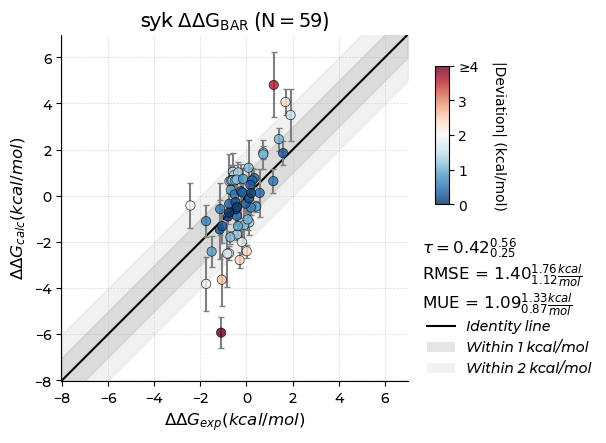

In [33]:
json_results = json.loads(Path("results/syk/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="syk",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isnull().sum())

fig.savefig("figures/syk_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/syk_regression.svg", bbox_inches="tight", facecolor="white")

In [34]:
fep_names = {}

chemio = MoleculeIO("perturbations/syk/ligands.sdf")
network_dict = json.loads(Path("perturbations/syk/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="syk"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## pfkfb3

2025-09-12 15:26:56 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:543 - Dropping FEPs with nan values: ['FEP_54_52' 'FEP_47_44' 'FEP_26_37' 'FEP_35_64' 'FEP_52_53' 'FEP_34_37']
2025-09-12 15:26:58 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.33_{0.13}^{0.51}$ RMSE = $1.68_{1.24}^{2.11}  \frac{kcal}{mol}$ MUE = $1.29_{1.01}^{1.62}  \frac{kcal}{mol}$


Crashes:  6


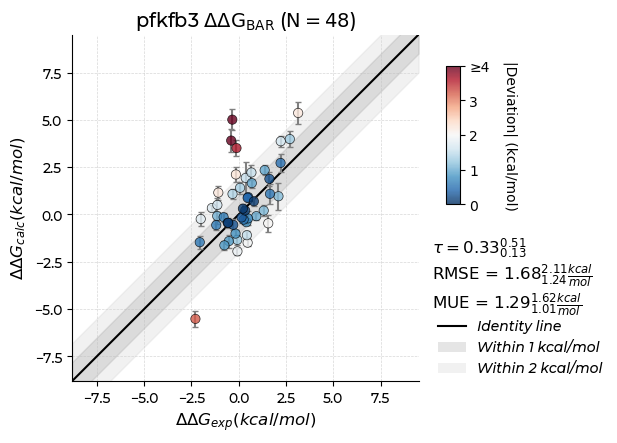

In [35]:
json_results = json.loads(Path("results/pfkfb3/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="pfkfb3",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

fig.savefig("figures/pfkfb3_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/pfkfb3_regression.svg", bbox_inches="tight", facecolor="white")

In [36]:
fep_names = {}

chemio = MoleculeIO("perturbations/pfkfb3/ligands.sdf")
network_dict = json.loads(Path("perturbations/pfkfb3/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "kartograf"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="pfkfb3"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## tnks2

2025-09-12 15:27:05 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:665 - Stats: $\tau = 0.30_{0.06}^{0.53}$ RMSE = $1.22_{0.97}^{1.45}  \frac{kcal}{mol}$ MUE = $1.03_{0.82}^{1.27}  \frac{kcal}{mol}$


Crashes:  0


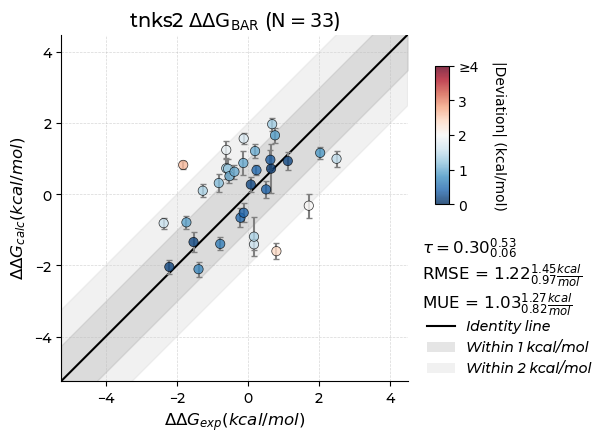

In [37]:
json_results = json.loads(Path("results/tnks2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tnks2",
)
set_font_properties(ax)
print("Crashes: ", df.Q_ddG_avg.isna().sum())
fig.savefig("figures/tnks2_regression.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/tnks2_regression.svg", bbox_inches="tight", facecolor="white")

In [38]:
fep_names = {}

chemio = MoleculeIO("perturbations/tnks2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tnks2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    )
    .reset_index(names=["fep_name"])
    .assign(target="tnks2"),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-09-12 15:27:07 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-09-12 15:27:07 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 8b. Reindexed.


# Investigate the error

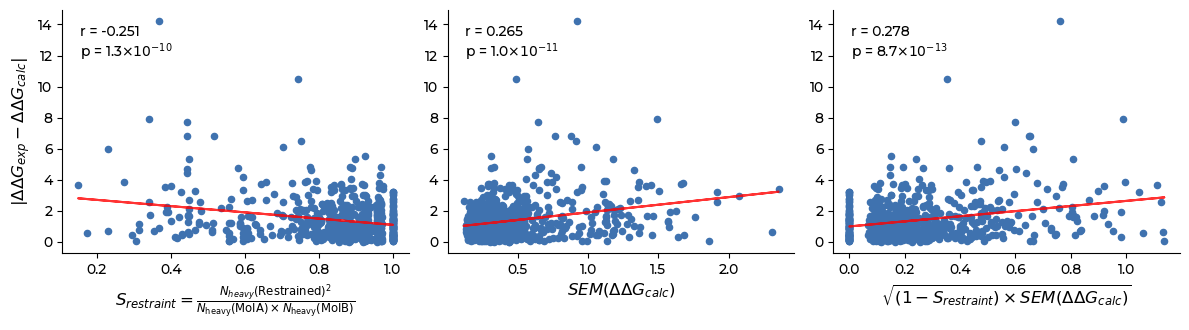

In [39]:
alldata = pd.concat(all_dataframes, ignore_index=True)
fig, axs = plt.subplots(ncols=3, figsize=(12, 3.4))

x_labels = [
    ### Similarity
    r"$S_{restraint}=\frac{N_{heavy}\text{(Restrained)}^2}{N_{\text{heavy}}\text{(MolA)} \times N_{\text{heavy}}\text{(MolB)}}$",
    ### Atom Number Difference (\Delta N_{\text{atoms}} =)
    # r"$|N_{\text{heavy}}\mathrm{MolA} - N_{\text{heavy}}\mathrm{MolB}|$ ",
    ### Unrestrained Atoms in the Bigger Molecule (U_{\text{bigger}} = )
    # r"$ \max(N_{\text{heavy}}\mathrm{MolA}, N_{\text{heavy}}\mathrm{MolB}) - N_{\text{restrained}}$ ",
    ### Difference in Number of Rings (\Delta N_{\text{rings}} = )
    # r"$|N_{\text{rings}}\mathrm{MolA} - N_{\text{rings}}\mathrm{MolB}|$",
    ### Perturbation SEM
    r"$SEM(\Delta\Delta G_{calc})$",
    r"$\sqrt{\left(1 - S_{restraint}\right) \times SEM(\Delta\Delta G_{calc})}$",
]
conditions = [
    "rest_simi",
    # "atom_n_diff",
    # "unrestrained_bigger_mol",
    # "diff_rings",
    "Q_ddG_sem",
    "score",
]

subset = (
    alldata.dropna(subset=["rest_simi", "residual"])
    .assign(abs_residual=lambda x: x["residual"].abs())
    .assign(score=lambda x: np.sqrt((1 - x["rest_simi"]) * x["Q_ddG_sem"]))
)

for i, (xlabel, x_col, ax) in enumerate(zip(x_labels, conditions, axs)):
    subset.plot.scatter(x=x_col, y="abs_residual", ax=ax, color="#3F72AF")

    data = subset[[x_col, "residual"]].dropna()
    x = data[x_col]
    y = data["residual"].abs()

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    if p_value < 0.001:
        p_text = f"{p_value:.1e}"
        number, exponent = p_text.split("e-")
        p_text = f"{number}$\\times10^{{-{exponent}}}$"
    else:
        p_text = f"{p_value:.3f}"

    ax.plot(x, p(x), alpha=0.8, color="red")
    if i == 0:
        ax.set_ylabel(r"$|\Delta\Delta G_{exp} - \Delta\Delta G_{calc}|$")
    else:
        ax.set_ylabel("")

    ax.set_xlabel(xlabel)

    ax.text(
        0.05,
        0.94,
        f"r = {correlation:.3f}\np = {p_text}",
        transform=ax.transAxes,
        verticalalignment="top",
        # bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontproperties=tick_font,
    )
    set_font_properties(ax)
    sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
fig = plt.gcf()
fig.savefig("figures/error-explanation.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("figures/error-explanation.svg", bbox_inches="tight", facecolor="white")
plt.show()

In [40]:
alldata.query("rest_simi < 0.3 & residual.abs() < 2")

,from,to,similarity,strict_flag,ddg_value,same_charge,Q_ddG_avg,Q_ddG_sem,Q_ddG_std,residual,fep_name,rest_simi,atom_n_diff,unrestrained_bigger_mol,diff_rings,target
319,18-flipped,24,0.449275,NaN,0.6345,True,-0.093625,1.175485,3.717209,0.728125,FEP_18-flipped_24,0.230769,2,14,1,cdk8
322,18-flipped,43,0.656716,NaN,-0.9593,True,-0.415482,1.362180,4.307591,-0.543818,FEP_18-flipped_43,0.173851,5,18,1,cdk8
544,CHEMBL3265020,docked-CHEMBL3264999-adjust,0.045049,False,-0.4100,True,-0.870500,0.396392,1.253500,0.460500,FEP_CHEMBL3265020_docked-CHEMBL3264999-adjust,0.294011,9,20,1,syk


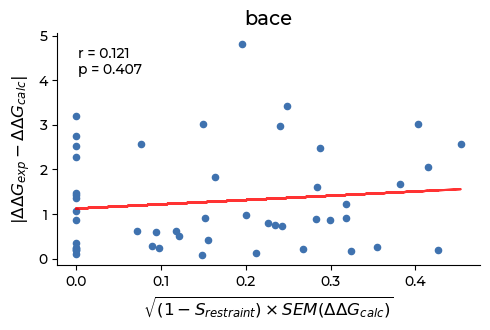

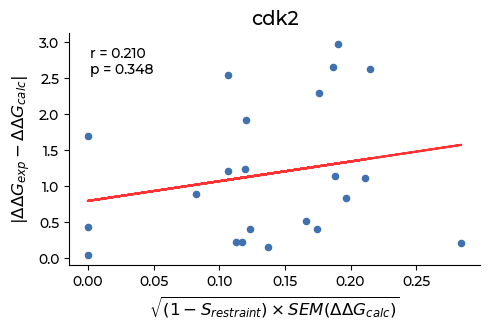

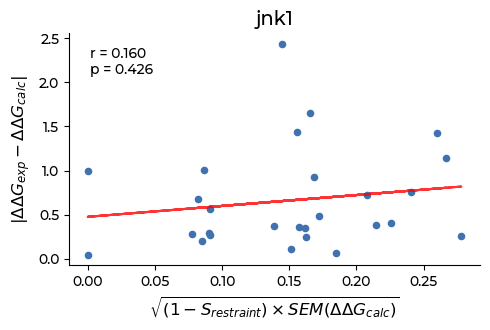

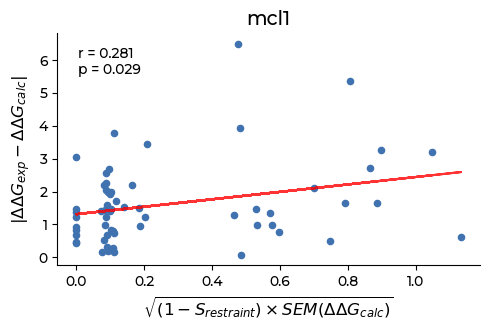

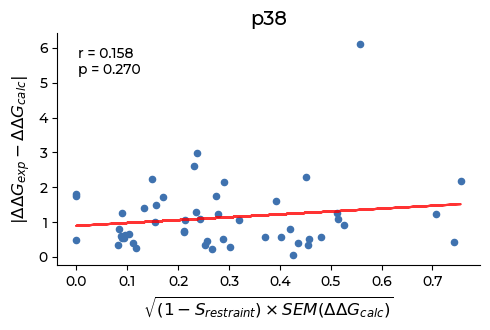

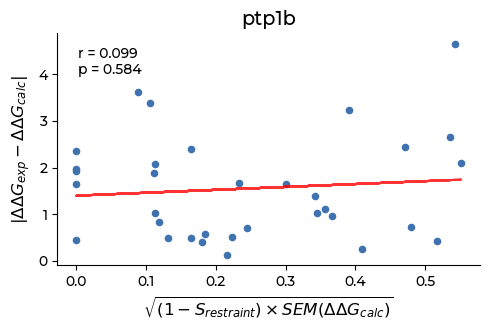

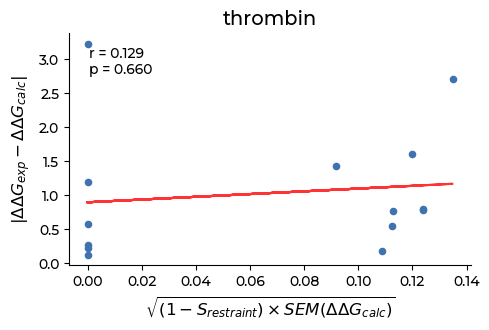

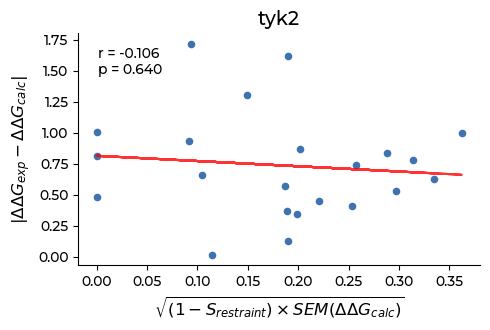

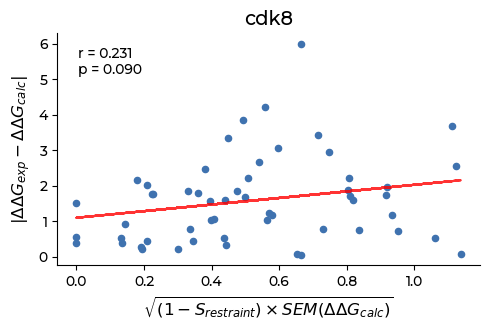

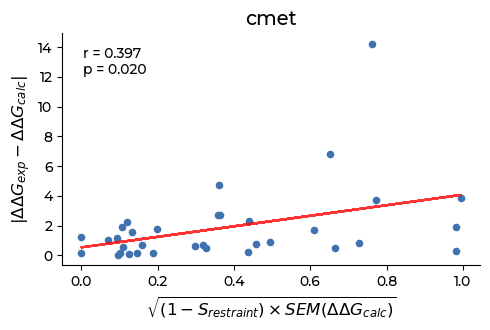

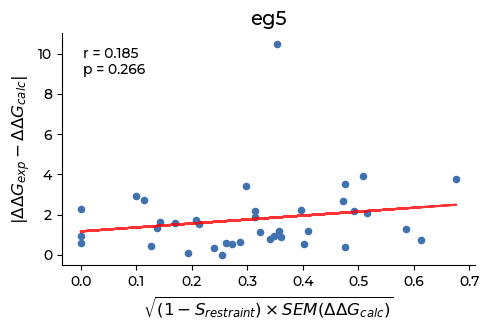

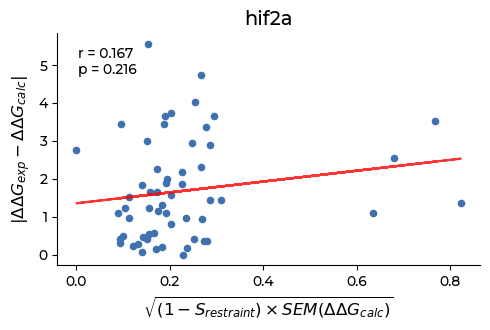

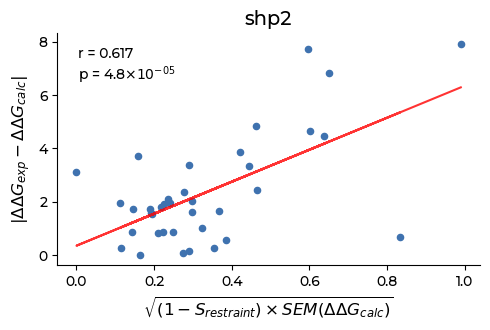

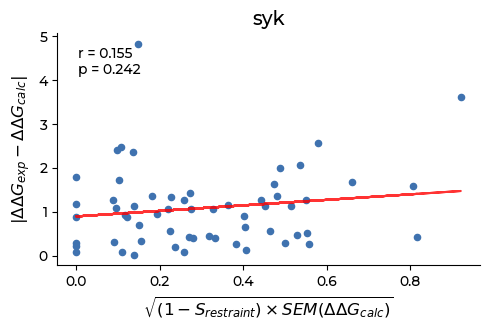

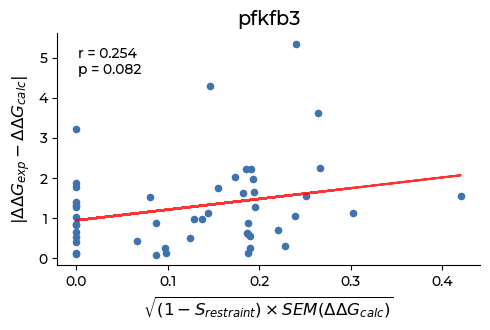

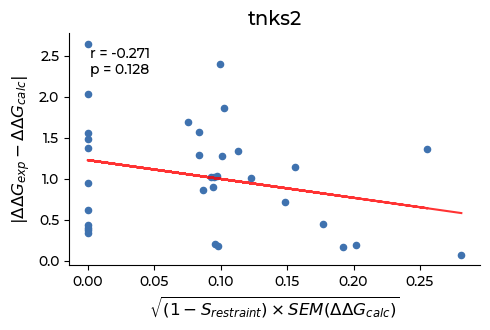

In [41]:
for target in alldata.target.unique():
    fig, ax = plt.subplots(figsize=(5, 3.4))

    xlabel = target

    subset = (
        alldata.query("target == @target")
        .dropna(subset=["rest_simi", "residual"])
        .assign(abs_residual=lambda x: x["residual"].abs())
        .assign(new_score=lambda x: np.sqrt((1 - x["rest_simi"]) * x["Q_ddG_sem"]))
    )

    subset.plot.scatter(x="new_score", y="abs_residual", ax=ax, color="#3F72AF")

    x = subset["new_score"]
    y = subset["abs_residual"]

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    if p_value < 0.001:
        p_text = f"{p_value:.1e}"
        number, exponent = p_text.split("e-")
        p_text = f"{number}$\\times10^{{-{exponent}}}$"
    else:
        p_text = f"{p_value:.3f}"

    ax.plot(x, p(x), alpha=0.8, color="red")

    ax.set_xlabel(r"$\sqrt{\left(1 - S_{restraint}\right) \times SEM(\Delta\Delta G_{calc})}$")
    ax.set_ylabel(r"$|\Delta\Delta G_{exp} - \Delta\Delta G_{calc}|$")
    ax.set_title(f"{xlabel}", size=14)

    ax.text(
        0.05,
        0.94,
        f"r = {correlation:.3f}\np = {p_text}",
        transform=ax.transAxes,
        verticalalignment="top",
        # bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontproperties=tick_font,
    )
    set_font_properties(ax)
    sns.despine(ax=ax, top=True, right=True)

    plt.tight_layout()
    fig = plt.gcf()

# Explore verbose energies

In [42]:
json_results = json.loads(Path("results/bace/mapping_ddG.json").read_text())
results_df = FepReader.prepare_df(json_results)

_path = Path("results/bace/bace_dgBar_verbose.parquet")

verbose_df = pd.read_parquet(_path)

pivoted = verbose_df.pivot_table(index=["system", "replicate", "fep"], columns="lambda_val", values=["dG"])
new_col_names = ["system", "replicate", "fep"] + [
    "-".join([c[0], str(c[1]).replace(".", "_")]) for c in pivoted.columns
]
pivoted = pivoted.reset_index()
pivoted.columns = new_col_names
pivoted = pivoted.rename(columns={"dG-0_0": "dG-0_000", "d-1_0": "dG-1_000"})

lambda_cols = [col for col in pivoted.columns if col.startswith("dG")]

results_df = results_df.rename(columns={"fep_name": "fep"})[
    ["Q_ddG_avg", "Q_ddG_sem", "ddg_value", "fep"]
].merge(pivoted, on="fep")

<Axes: xlabel='lambda_val', ylabel='value'>

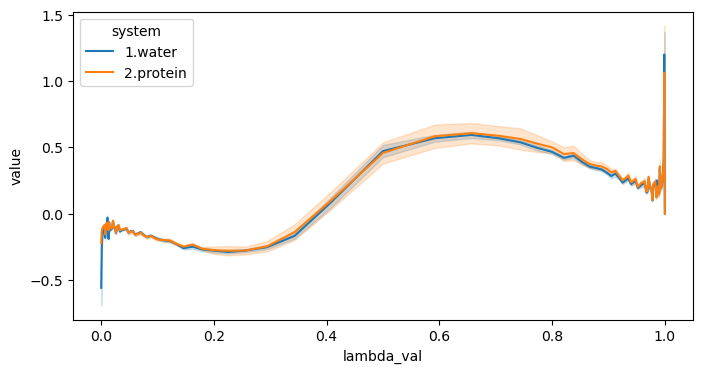

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    pivoted.query('fep == "FEP_CAT-13a_CAT-13c"')
    .melt(id_vars=["system", "replicate", "fep"], value_vars=lambda_cols)
    .assign(lambda_val=lambda x: x["variable"].str.split("-").apply(lambda y: float(y[1].replace("_", ".")))),
    x="lambda_val",
    y="value",
    hue="system",
    markers=True,
    ax=ax,
    errorbar="sd",
)

# Compare Results

## Imports & Functions

In [44]:
# adapted from https://github.com/OpenFreeEnergy/cinnabar/blob/main/cinnabar/stats.py
def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 1000,
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
    return_verbose: bool = False,
    seed: Union[int, None] = None,
) -> dict:
    """Compute mean and confidence intervals of specified statistic.

    Args:
        y_true: True values
        y_pred: Predicted values
        dy_true: Errors of true values. If None, the values are assumed to have no errors
        dy_pred: Errors of predicted values. If None, the values are assumed to have no errors
        ci: Interval for confidence interval (CI)
        statistic: Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
        nbootstrap: Number of bootstrap samples
        include_true_uncertainty: whether to account for the uncertainty in y_true when bootstrapping
        include_pred_uncertainty: whether to account for the uncertainty in y_pred when bootstrapping
        return_verbose: whether to return the all the metrics calculated with the bootstrap samples
        seed: A seed for the random number generator to ensure reproducibility.

    Returns:
        rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == "MUE":
            return mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = stats.linregress(y_true_sample, y_pred_sample)
            return r_value**2
        elif statistic == "rho":
            return stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)

    rng = np.random.default_rng(seed)
    s_n = np.zeros([nbootstrap], np.float64)  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        # 1. Get all random indices for this replicate at once
        indices = rng.choice(np.arange(sample_size), size=sample_size, replace=True)

        # 2. Create the resampled datasets using array indexing
        y_true_resampled = y_true[indices]
        y_pred_resampled = y_pred[indices]
        dy_true_resampled = dy_true[indices]
        dy_pred_resampled = dy_pred[indices]

        # 3. Add uncertainty in a vectorized way (if requested)
        if include_true_uncertainty:
            y_true_sample = rng.normal(loc=y_true_resampled, scale=np.fabs(dy_true_resampled))
        else:
            y_true_sample = y_true_resampled

        if include_pred_uncertainty:
            y_pred_sample = rng.normal(loc=y_pred_resampled, scale=np.fabs(dy_pred_resampled))
        else:
            y_pred_sample = y_pred_resampled

        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    low_percentile = (1.0 - ci) / 2.0 * 100
    high_percentile = (1.0 + ci) / 2.0 * 100
    rmse_stats["low"], rmse_stats["high"] = np.percentile(s_n, [low_percentile, high_percentile])
    if return_verbose:
        rmse_stats["all"] = s_n
    return rmse_stats


def clean_latex_strings(text):
    """
    Find LaTeX-like strings with the form $value_{lower}^{upper}$
    and transform them by removing $, {, } symbols and replacing '^' with '_'.
    """
    pattern = r"\$([^\$_]+)_\{([^\}]+)\}\^\{([^\}]+)\}\$"

    def replacement(match):
        value, lower, upper = match.groups()
        return f"{value}_{lower}_{upper}"

    return re.sub(pattern, replacement, text)


def take_value(string, which="sub"):
    values = string.split("_")
    if which == "mean":
        return float(values[0])
    elif which == "sub":
        return float(values[1])
    elif which == "sup":
        return float(values[2])


def get_metrics_df(
    results_df: pd.DataFrame,
    statistics: list,
    pred_col: str,
    exp_col: str,
    targets: Union[Optional[list], str] = None,
    return_verbose: bool = False,
    seed: Optional[int] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Get metrics DataFrame from results DataFrame.

    Args:
        results_df: DataFrame containing the results.
        statistics: List of statistics to compute.
        pred_col: Name of the column with predicted values.
        exp_col: Name of the column with experimental values.
        targets: Optional list of target names to include. If left as None, just calculate
            the overall metrics, without taking targets into consideration. If "all", calculate
            per-target metrics *and* the overall performance, with all targets included.
        return_verbose: Whether to return verbose output. Defaults to False.
        seed: Random seed for reproducibility. Defaults to None.

    Returns:
        DataFrame with the computed metrics.
    """
    results_dict = {}
    all_res = []

    if targets is None:
        target_items = [("overall", results_df)]
    elif targets == "all":
        target_items = [(target, results_df.query("target == @target")) for target in targets]
        target_items.append(("overall", results_df))
    else:
        target_items = [(target, results_df.query("target == @target")) for target in targets]

    def result_to_latex(res, target_name, stat):
        """Convert bootstrap result to LaTeX format"""
        mle = round(res["mle"], 2)
        low = round(res["low"], 2)
        high = round(res["high"], 2)

        if return_verbose:
            all_res.append(
                pd.DataFrame(res["all"], columns=["value"]).assign(target=target_name, statistic=stat)
            )

        return f"${mle}_{{{low}}}^{{{high}}}$"

    # Calculate metrics for each statistic
    for stat in statistics + ["N"]:
        dictionary = {stat: {}}

        for target_name, subset in target_items:
            if stat == "N":
                dictionary[stat][target_name] = len(subset)
            else:
                res = bootstrap_statistic(
                    subset[pred_col].values,
                    subset[exp_col].values,
                    statistic=stat,
                    return_verbose=return_verbose,
                    seed=seed,
                )
                dictionary[stat][target_name] = result_to_latex(res, target_name, stat)

        results_dict.update(dictionary)

    metrics_df = pd.DataFrame().from_dict(results_dict)
    return metrics_df, pd.concat(all_res, ignore_index=True) if return_verbose else metrics_df


def plot_single_point_metrics(
    single_point_df: pd.DataFrame,
    calc_col: str = "Q_ddG_avg",
    exp_col: str = "ddg_value",
    target_col: str = "target",
    metrics: list = ["KTAU", "MAE"],
    figsize: tuple = (8, 6),
):
    """
    Plot single-point metrics for JACS and Merck targets.

    Parameters:
        single_point_df: DataFrame containing the single-point metrics.
        calc_col: Column name for calculated values.
        exp_col: Column name for experimental values.
        target_col: Column name for target identifiers.
        metrics): List of metrics to plot.
        figsizee): Size of the figure.
    """

    single_point = []

    for target in single_point_df[target_col].unique():
        ktau = kendalltau(
            x=single_point_df.query(f"{target_col}==@target")[calc_col],
            y=single_point_df.query(f"{target_col}==@target")[exp_col],
        )[0]
        mae = mean_absolute_error(
            y_true=single_point_df.query(f"{target_col}==@target")[exp_col],
            y_pred=single_point_df.query(f"{target_col}==@target")[calc_col],
        )
        single_point.append([target, ktau, mae])

    single_point_df = pd.DataFrame(single_point, columns=["target", "KTAU", "MAE"]).set_index("target")

    fig, axs = plt.subplots(nrows=len(metrics), figsize=figsize)

    colors = ["skyblue", "lightcoral"]
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        single_point_df[metric].plot(
            kind="bar", ax=axs[i], color=color, rot=45, ylabel=metric, edgecolor="black"
        )
        axs[i].set_title(f"Single-point {metric} for JACS and Merck targets")
        axs[i].grid(axis="y", alpha=0.3)
        axs[i].set_axisbelow(True)

    plt.tight_layout()

## Load our data

In [45]:
jacs_targs = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    # "ptp1b2xSampled",
    "ptp1b",
    "thrombin",
    "tyk2",
]
merck_targs = [
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]
targets = jacs_targs + merck_targs

In [46]:
qligfep_result_df = []

for targ in targets:
    fpath = Path(f"results/{targ}/mapping_ddG.json")
    if not fpath.exists():
        print(f"Skipping {targ}")
        continue

    json_results = json.loads(fpath.read_text())

    df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()").assign(target=targ)

    qligfep_result_df.append(df)

qligfep_result_df = pd.concat(qligfep_result_df).assign(
    target=lambda x: x["target"].replace({"ptp1b2xSampled": "ptp1b", "cdk8ManualMapping": "cdk8"})
)

# Calculate $\Delta G$ from $\Delta\Delta G$

In [47]:
def get_most_connected_node(data, lig1col="from", lig2col="to", ddG_col="Q_ddG_avg"):
    G = nx.DiGraph()
    for _, edge in data.iterrows():
        G.add_edge(edge[lig1col], edge[lig2col], weight=edge[ddG_col])
        G.add_edge(edge[lig2col], edge[lig1col], weight=-edge[ddG_col])
    most_connected = max(G.degree, key=lambda x: x[1])[0]
    return most_connected


def load_single_node_dG(mapping_path, node_name):
    mapping_dict = json.loads(mapping_path.read_text())
    return mapping_dict["nodes"][node_name]["dg_value"]


def find_connected_components(data, from_col="from", to_col="to"):
    """
    Identifies disconnected subgraphs (connected components) in the data.

    Args:
        data (pd.DataFrame): DataFrame containing the edge list.
        from_col (str): The name of the column representing the starting node of an edge.
        to_col (str): The name of the column representing the ending node of an edge.

    Returns:
        tuple: A tuple containing:
            - int: The number of disconnected components (subgraphs).
            - list: A list of lists, where each inner list contains the
                    original DataFrame indices of the edges belonging to one component.
    """
    G = nx.from_pandas_edgelist(data, source=from_col, target=to_col)
    component_nodes = list(nx.connected_components(G))

    component_indices = []
    for nodes in component_nodes:
        mask = data[from_col].isin(nodes) & data[to_col].isin(nodes)

        indices = data.index[mask].tolist()
        component_indices.append(indices)

    return (len(component_nodes), component_indices)

## Cycle closure correction for QligFEP results
For this, we use the [State Function-Based Correction](https://doi.org/10.1021/acs.jpclett.5c01119) method.

To install, run: `python -m pip install git+https://github.com/David-Araripe/SFC_FreeEnergyCorrection.git`

<!-- # Before I was doing with the `WeightedCCC` package, but it was slow for D. Hahn's data, so I'm using `SFC_FreeEnergyCorrection`. I'm adding the code here because of my FOMO... What if we need it later?

from WeightedCCC.graph import GraphClosure
from WeightedCCC.calc_lig import (
    set_node_map,
    cal_node_path_independent_error,
    cal_node_path_dependent_error,
    calcMolEnes,
    getMolEnergyDataFrame,
)

qligfep_dG_dfs = []

for target in qligfep_result_df.target.unique():
    print(target)

    target_subset = qligfep_result_df.query("target == @target").copy()
    n_subgraphs, idxs = find_connected_components(target_subset)

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        g = GraphClosure(
            from_lig=subtraph_subset["from"].tolist(),
            to_lig=subtraph_subset["to"].tolist(),
            b_ddG=subtraph_subset["Q_ddG_avg"].tolist(),
            # weights=qligfep_result_df["Q_ddG_sem"].tolist(),
        )

        most_connected = get_most_connected_node(subtraph_subset)
        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        ref_dG = load_single_node_dG(path_template, most_connected)

        g.getAllCyles()
        g.iterateCycleClosure(minimum_cycles=2)
        # g.getEnergyPairsDataFrame(verbose=True)
        node_map = set_node_map(g)
        path_independent_error = cal_node_path_independent_error(g.V, node_map)
        path_dependent_error, path = cal_node_path_dependent_error(most_connected, g.V, node_map)
        mol_ene = calcMolEnes(ref_dG, g, path)
        ene_df = getMolEnergyDataFrame(
            g.V, mol_ene, path_dependent_error, path_independent_error, verbose=False
        )
        qligfep_dG_dfs.append(ene_df.assign(target=target))

qligfep_dG_dfs = pd.concat(qligfep_dG_dfs, ignore_index=True)

 -->

 <!-- Another option is doing it with MLE, the methods used in Hahn et al's paper.
 I tried it but it seems less robsut than the SFC method. Here's the code I tried (FOMO):

 from cinnabar import femap
from openff.units import unit
from cinnabar import ReferenceState, Measurement

mapping_path = Path("results/bace/mapping_ddG.json")


def add_dG_to_mapping_file(mapping_path):

    mapping_dict = json.loads(mapping_path.read_text())

    nodes = pd.DataFrame.from_dict(mapping_dict["nodes"], orient="index").reset_index(names="ligand")
    edges = pd.DataFrame(mapping_dict["edges"])

    kcalmol = unit.kilocalorie_per_mole
    g = ReferenceState()
    fe = femap.FEMap()

    for _, row in nodes.iterrows():
        fe.add_measurement(
            Measurement(
                labelA=g,
                labelB=row["ligand"],
                DG=row["dg_value"] * kcalmol,
                uncertainty=0.0 * kcalmol,
                computational=False,
            )
        )
    for _, row in edges.iterrows():
        if pd.isna(row["Q_ddG_avg"]):
            continue
        else:
            fe.add_measurement(
                Measurement(
                    labelA=row["from"],
                    labelB=row["to"],
                    DG=row["Q_ddG_avg"] * kcalmol,
                    uncertainty=row["Q_ddG_sem"] * kcalmol,
                    computational=True,
                )
            )

    fe.generate_absolute_values()
    df = fe.get_absolute_dataframe().query('source == "MLE"')

    Q_dG_values = (
        df.set_index("label")
        .rename(columns={"DG (kcal/mol)": "QdG", "uncertainty (kcal/mol)": "Q-SEMdG"})
        .drop(columns=["source", "computational"])
        .to_dict(orient="index")
    )

    for node in mapping_dict["nodes"]:
        try:
            mapping_dict["nodes"][node]["QdG"] = Q_dG_values[node]["QdG"]
        except KeyError:
            mapping_dict["nodes"][node]["QdG"] = None
        try:
            mapping_dict["nodes"][node]["Q-SEMdG"] = Q_dG_values[node]["QdG"]
        except KeyError:
            mapping_dict["nodes"][node]["Q-SEMdG"] = None

    with mapping_path.open("w"):
        json.dump(mapping_dict, mapping_path.open("w"), indent=2)
    return mapping_dict


all_mapping_files = sorted(Path().glob("results/*/mapping_ddG.json"))
for mapfile in all_mapping_files:
    print(f"Processing {mapfile}")
    try:
        add_dG_to_mapping_file(mapfile)
    except ValueError as e:
        print(f"Skipping {mapfile} due to error: {e}")
        continue
    
>>> Processing results/bace/mapping_ddG.json
>>> Processing results/cdk2/mapping_ddG.json
>>> Processing results/cdk8/mapping_ddG.json
>>> Processing results/cdk8ManualMapping/mapping_ddG.json
>>> Processing results/cmet/mapping_ddG.json
>>> Skipping results/cmet/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/eg5/mapping_ddG.json
>>> Skipping results/eg5/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/hif2a/mapping_ddG.json
>>> Skipping results/hif2a/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/jnk1/mapping_ddG.json
>>> Processing results/mcl1/mapping_ddG.json
>>> Processing results/p38/mapping_ddG.json
>>> Processing results/pfkfb3/mapping_ddG.json
>>> Processing results/ptp1b/mapping_ddG.json
>>> Processing results/ptp1b2xSampled/mapping_ddG.json
>>> Processing results/shp2/mapping_ddG.json
>>> Processing results/syk/mapping_ddG.json
>>> Skipping results/syk/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/thrombin/mapping_ddG.json
>>> Processing results/tnks2/mapping_ddG.json
>>> Skipping results/tnks2/mapping_ddG.json due to error: Computational results are not fully connected
>>> Processing results/tyk2/mapping_ddG.json
  -->

In [48]:
from SFC_FreeEnergyCorrection.data_loader import DataLoader
from SFC_FreeEnergyCorrection.apply_sfc import run_and_process_results

qligfep_dG_dfs = []

for target in qligfep_result_df.target.unique():
    print(target)

    target_subset = qligfep_result_df.query("target == @target").copy()
    n_subgraphs, idxs = find_connected_components(target_subset)

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        most_connected = get_most_connected_node(subtraph_subset)
        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        ref_dG = load_single_node_dG(path_template, most_connected)

        dl = DataLoader(
            from_lig=subtraph_subset["from"].tolist(),
            to_lig=subtraph_subset["to"].tolist(),
            b_ddG=subtraph_subset["Q_ddG_avg"].tolist(),
            err_b_ddG=qligfep_result_df["Q_ddG_sem"].tolist(),
            ref_mol=most_connected,
        )

        result = run_and_process_results(dl, ref_energy=ref_dG, include_pairs=True)
        ene_df = result["sfc"]["node_results"]
        qligfep_dG_dfs.append(ene_df.assign(target=target))

qligfep_dG_dfs = pd.concat(qligfep_dG_dfs, ignore_index=True)

2025-09-12 15:27:14,488 - INFO - Rank check: rank(A) = 35, N = 36
2025-09-12 15:27:14,489 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:14,489 - INFO - cond(A_aug) [SFC check] = 2.31e+01
2025-09-12 15:27:14,490 - INFO - cond(Aw_aug) [WSFC check] = 1.36e+03
2025-09-12 15:27:14,490 - WARNING - cond(Aw_aug) = 1.36e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:14,491 - INFO - Running Standard Optimization mode...


bace


2025-09-12 15:27:14,738 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:14,748 - INFO - Rank check: rank(A) = 15, N = 16
2025-09-12 15:27:14,748 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:14,749 - INFO - cond(A_aug) [SFC check] = 1.34e+01
2025-09-12 15:27:14,749 - INFO - cond(Aw_aug) [WSFC check] = 3.96e+02
2025-09-12 15:27:14,750 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:14,796 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:14,805 - INFO - Rank check: rank(A) = 20, N = 21
2025-09-12 15:27:14,805 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:14,806 - INFO - cond(A_aug) [SFC check] = 1.65e+01
2025-09-12 15:27:14,806 - INFO - cond(Aw_aug) [WSFC check] = 5.46e+02
2025-09-12 15:27:14,807 - INFO - Running St

cdk2
jnk1
mcl1


2025-09-12 15:27:15,215 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:15,227 - INFO - Rank check: rank(A) = 33, N = 34
2025-09-12 15:27:15,227 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:15,228 - INFO - cond(A_aug) [SFC check] = 2.43e+01
2025-09-12 15:27:15,229 - INFO - cond(Aw_aug) [WSFC check] = 1.66e+03
2025-09-12 15:27:15,229 - WARNING - cond(Aw_aug) = 1.66e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:15,230 - INFO - Running Standard Optimization mode...


p38


2025-09-12 15:27:15,435 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:15,445 - INFO - Rank check: rank(A) = 22, N = 23
2025-09-12 15:27:15,446 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:15,446 - INFO - cond(A_aug) [SFC check] = 1.73e+01
2025-09-12 15:27:15,447 - INFO - cond(Aw_aug) [WSFC check] = 6.99e+02
2025-09-12 15:27:15,448 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:15,546 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:15,554 - INFO - Rank check: rank(A) = 10, N = 11
2025-09-12 15:27:15,554 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:15,555 - INFO - cond(A_aug) [SFC check] = 9.99e+00
2025-09-12 15:27:15,556 - INFO - cond(Aw_aug) [WSFC check] = 1.91e+02
2025-09-12 15:27:15,556 - INFO - Running St

ptp1b
thrombin
tyk2
cdk8


2025-09-12 15:27:15,804 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:15,814 - INFO - Rank check: rank(A) = 11, N = 12
2025-09-12 15:27:15,814 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:15,814 - INFO - cond(A_aug) [SFC check] = 1.09e+01
2025-09-12 15:27:15,815 - INFO - cond(Aw_aug) [WSFC check] = 3.08e+02
2025-09-12 15:27:15,815 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:15,837 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:15,841 - INFO - Rank check: rank(A) = 11, N = 12
2025-09-12 15:27:15,841 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:15,841 - INFO - cond(A_aug) [SFC check] = 1.00e+01
2025-09-12 15:27:15,842 - INFO - cond(Aw_aug) [WSFC check] = 2.27e+02
2025-09-12 15:27:15,842 - INFO - Running St

cmet
Found 2 disconnected components in cmet. Processing one at a time.
eg5
Found 2 disconnected components in eg5. Processing one at a time.
hif2a
Found 2 disconnected components in hif2a. Processing one at a time.


2025-09-12 15:27:16,144 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:16,150 - INFO - Rank check: rank(A) = 7, N = 8
2025-09-12 15:27:16,150 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:16,151 - INFO - cond(A_aug) [SFC check] = 7.50e+00
2025-09-12 15:27:16,151 - INFO - cond(Aw_aug) [WSFC check] = 1.05e+02
2025-09-12 15:27:16,152 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:16,164 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:16,172 - INFO - Rank check: rank(A) = 25, N = 26
2025-09-12 15:27:16,172 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:16,173 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-09-12 15:27:16,174 - INFO - cond(Aw_aug) [WSFC check] = 8.00e+02
2025-09-12 15:27:16,174 - INFO - Running Stan

shp2
syk
Found 2 disconnected components in syk. Processing one at a time.


2025-09-12 15:27:16,606 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:16,612 - INFO - Rank check: rank(A) = 5, N = 6
2025-09-12 15:27:16,612 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:16,613 - INFO - cond(A_aug) [SFC check] = 6.57e+00
2025-09-12 15:27:16,613 - INFO - cond(Aw_aug) [WSFC check] = 9.49e+01
2025-09-12 15:27:16,614 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:16,621 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:16,630 - INFO - Rank check: rank(A) = 37, N = 38
2025-09-12 15:27:16,630 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:16,631 - INFO - cond(A_aug) [SFC check] = 2.70e+01
2025-09-12 15:27:16,632 - INFO - cond(Aw_aug) [WSFC check] = 1.33e+03
2025-09-12 15:27:16,632 - WARNING - cond(Aw_a

pfkfb3


2025-09-12 15:27:16,953 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:16,966 - INFO - Rank check: rank(A) = 20, N = 21
2025-09-12 15:27:16,966 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:16,967 - INFO - cond(A_aug) [SFC check] = 1.57e+01
2025-09-12 15:27:16,968 - INFO - cond(Aw_aug) [WSFC check] = 5.85e+02
2025-09-12 15:27:16,968 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:17,035 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:17,040 - INFO - Rank check: rank(A) = 5, N = 6
2025-09-12 15:27:17,040 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:17,041 - INFO - cond(A_aug) [SFC check] = 6.27e+00
2025-09-12 15:27:17,041 - INFO - cond(Aw_aug) [WSFC check] = 3.87e+01
2025-09-12 15:27:17,042 - INFO - Running Stan

tnks2
Found 2 disconnected components in tnks2. Processing one at a time.


In [49]:
qligfep_dG_dfs = qligfep_dG_dfs.rename(
    columns={
        "Ligand": "Node",
        "Energy": "sfc_dG",
        "Path_Dep_Error": "path_dep_error",
        "Path_Indep_Error": "path_indep_error",
    },
)

In [50]:
single_node_exp_values = []
for target in qligfep_dG_dfs.target.unique():
    path_template = Path("results/{target}/mapping_ddG.json".format(target=target))
    single_node_df = (
        pd.DataFrame.from_dict(json.loads(path_template.read_text())["nodes"], orient="index")
        .assign(target=target)
        .reset_index(names=["Node"])
    )
    single_node_exp_values.append(single_node_df[["Node", "dg_value", "target"]])

single_node_exp_values = pd.concat(single_node_exp_values)
qligfep_dG_dfs = qligfep_dG_dfs.merge(
    single_node_exp_values,
    on=["target", "Node"],
    how="left",
)

In [51]:
# plot_single_point_metrics(qligfep_dG_dfs, calc_col="sfc_dG", exp_col="dg_value")
# plot_single_point_metrics(qligfep_result_df, calc_col="Q_ddG_avg", exp_col="ddg_value", target_col="target")

## Fetch other data for comparison

In [52]:
html_root = "https://raw.githubusercontent.com/dfhahn/protein-ligand-benchmark-analysis/refs/heads/master"

res = requests.get(f"{html_root}/03_comparison_experiment/03a_all_edges_all_ffs.csv")
res.raise_for_status()

targets = (
    pd.Series(targets)
    .replace(
        {
            # "ptp1b2xSampled": "ptp1b",
            "cdk8ManualMapping": "cdk8",
        }
    )
    .tolist()
)
hahn_results = (
    pd.read_csv(StringIO(res.text), index_col=0).reset_index(names=["FEP_ID"]).query("target.isin(@targets)")
)

res = requests.get(f"{html_root}/03_comparison_experiment/03b_all_ligands_all_ffs.csv")
res.raise_for_status()
hahn_nodes = (
    pd.read_csv(StringIO(res.text), index_col=0).reset_index(names=["FEP_ID"]).query("target.isin(@targets)")
)

In [53]:
hahn_results.columns

Index(['FEP_ID', 'target', 'edge', 'ligandA', 'ligandB', 'unit', 'DDG_Exp.',
       'dDDG_Exp.', 'DDG_OpenFF-1.0', 'dDDG_OpenFF-1.0',
       'DDG_OpenFF-1.0_converged', 'dDDG_OpenFF-1.0_converged',
       'DDG_OpenFF-1.2', 'dDDG_OpenFF-1.2', 'DDG_OpenFF-1.2_converged',
       'dDDG_OpenFF-1.2_converged', 'DDG_OpenFF-2.0', 'dDDG_OpenFF-2.0',
       'DDG_OpenFF-2.0_converged', 'dDDG_OpenFF-2.0_converged', 'DDG_OPLS3e',
       'dDDG_OPLS3e', 'DDG_GAFF2', 'dDDG_GAFF2', 'DDG_cGenFF', 'dDDG_cGenFF',
       'DDG_Consensus_OpenFF_GAFF2_cGenFF',
       'dDDG_Consensus_OpenFF_GAFF2_cGenFF', 'DDG_Consensus_OpenFF_GAFF2',
       'dDDG_Consensus_OpenFF_GAFF2', 'DDG_Consensus_all',
       'dDDG_Consensus_all', 'error_OpenFF-1.0', 'abserror_OpenFF-1.0',
       'error_OpenFF-1.0_converged', 'abserror_OpenFF-1.0_converged',
       'error_OpenFF-1.2', 'abserror_OpenFF-1.2', 'error_OpenFF-1.2_converged',
       'abserror_OpenFF-1.2_converged', 'error_OpenFF-2.0',
       'abserror_OpenFF-2.0', 'error_Open

In [54]:
hahn_results["OpenFF20_residual"] = hahn_results["DDG_Exp."] - hahn_results["DDG_OpenFF-2.0"]
hahn_results["OPLS3e_residual"] = hahn_results["DDG_Exp."] - hahn_results["DDG_OPLS3e"]

## Cycle Closure Correction for D. Hahn's results

In [55]:
from itertools import product

dHahn_dG_dfs = []

values = ["DDG_OpenFF-2.0", "DDG_OPLS3e"]

for val, target in product(values, targets):
    print(target)

    target_subset = hahn_results.query("target == @target").dropna(subset=[val]).copy()
    n_subgraphs, idxs = find_connected_components(target_subset, from_col="ligandA", to_col="ligandB")

    if n_subgraphs > 1:
        print(f"Found {n_subgraphs} disconnected components in {target}. Processing one at a time.")

    for sub_idxs in idxs:
        subtraph_subset = target_subset.loc[sub_idxs].copy()

        most_connected = get_most_connected_node(
            subtraph_subset, lig1col="ligandA", lig2col="ligandB", ddG_col=val
        )

        path_template = Path("results/{target}/mapping_ddG.json".format(target=target))

        if most_connected == "SHP099-1":  # I don't know why but it's named like this
            ref_dG = load_single_node_dG(path_template, "SHP099-1-Example-7")
        else:
            ref_dG = load_single_node_dG(path_template, most_connected.replace(f"{target}a_", ""))

        dl = DataLoader(
            from_lig=subtraph_subset["ligandA"].tolist(),
            to_lig=subtraph_subset["ligandB"].tolist(),
            b_ddG=subtraph_subset[val].tolist(),
            err_b_ddG=subtraph_subset[f"d{val}"].tolist(),
            ref_mol=most_connected,
        )

        result = run_and_process_results(dl, ref_energy=ref_dG, include_pairs=True)
        ene_df = result["sfc"]["node_results"]
        dHahn_dG_dfs.append(ene_df.assign(target=target, value=val))

dHahn_dG_dfs = pd.concat(dHahn_dG_dfs, ignore_index=True)

2025-09-12 15:27:17,673 - INFO - Rank check: rank(A) = 35, N = 36
2025-09-12 15:27:17,674 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:17,674 - INFO - cond(A_aug) [SFC check] = 2.43e+01
2025-09-12 15:27:17,675 - INFO - cond(Aw_aug) [WSFC check] = 3.41e+03
2025-09-12 15:27:17,676 - WARNING - cond(Aw_aug) = 3.41e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.


2025-09-12 15:27:17,676 - INFO - Running Standard Optimization mode...


bace


2025-09-12 15:27:17,980 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:17,998 - INFO - Rank check: rank(A) = 15, N = 16
2025-09-12 15:27:17,998 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:17,999 - INFO - cond(A_aug) [SFC check] = 1.33e+01
2025-09-12 15:27:17,999 - INFO - cond(Aw_aug) [WSFC check] = 5.78e+02
2025-09-12 15:27:17,999 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:18,038 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:18,053 - INFO - Rank check: rank(A) = 20, N = 21
2025-09-12 15:27:18,053 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:18,054 - INFO - cond(A_aug) [SFC check] = 1.69e+01
2025-09-12 15:27:18,055 - INFO - cond(Aw_aug) [WSFC check] = 9.62e+02
2025-09-12 15:27:18,055 - INFO - Running St

cdk2
jnk1
mcl1


2025-09-12 15:27:18,546 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:18,564 - INFO - Rank check: rank(A) = 33, N = 34
2025-09-12 15:27:18,565 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:18,565 - INFO - cond(A_aug) [SFC check] = 2.57e+01
2025-09-12 15:27:18,566 - INFO - cond(Aw_aug) [WSFC check] = 3.00e+03
2025-09-12 15:27:18,566 - WARNING - cond(Aw_aug) = 3.00e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:18,567 - INFO - Running Standard Optimization mode...


p38


2025-09-12 15:27:18,788 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:18,805 - INFO - Rank check: rank(A) = 22, N = 23
2025-09-12 15:27:18,805 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:18,806 - INFO - cond(A_aug) [SFC check] = 1.81e+01
2025-09-12 15:27:18,806 - INFO - cond(Aw_aug) [WSFC check] = 1.86e+03
2025-09-12 15:27:18,806 - WARNING - cond(Aw_aug) = 1.86e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:18,807 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:18,924 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:18,941 - INFO - Rank check: rank(A) = 10, N = 11
2025-09-12 15:27:18,942 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:18,942 - INFO - cond(A_aug) [SFC check] = 1.0

ptp1b
thrombin
tyk2


2025-09-12 15:27:19,012 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:19,028 - INFO - Rank check: rank(A) = 32, N = 33
2025-09-12 15:27:19,028 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:19,029 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-09-12 15:27:19,029 - INFO - cond(Aw_aug) [WSFC check] = 3.66e+03
2025-09-12 15:27:19,030 - WARNING - cond(Aw_aug) = 3.66e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:19,030 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:19,174 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:19,191 - INFO - Rank check: rank(A) = 23, N = 24
2025-09-12 15:27:19,192 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:19,192 - INFO - cond(A_aug) [SFC check] = 1.7

cdk8
cmet


2025-09-12 15:27:19,365 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:19,382 - INFO - Rank check: rank(A) = 27, N = 28
2025-09-12 15:27:19,382 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:19,383 - INFO - cond(A_aug) [SFC check] = 1.98e+01
2025-09-12 15:27:19,384 - INFO - cond(Aw_aug) [WSFC check] = 7.52e+03
2025-09-12 15:27:19,384 - WARNING - cond(Aw_aug) = 7.52e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:19,384 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:19,566 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).


eg5
hif2a


2025-09-12 15:27:19,585 - INFO - Rank check: rank(A) = 41, N = 42
2025-09-12 15:27:19,586 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:19,587 - INFO - cond(A_aug) [SFC check] = 2.34e+01
2025-09-12 15:27:19,588 - INFO - cond(Aw_aug) [WSFC check] = 4.87e+03
2025-09-12 15:27:19,588 - WARNING - cond(Aw_aug) = 4.87e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:19,588 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:19,832 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:19,850 - INFO - Rank check: rank(A) = 25, N = 26
2025-09-12 15:27:19,851 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:19,852 - INFO - cond(A_aug) [SFC check] = 2.07e+01
2025-09-12 15:27:19,852 - INFO - cond(Aw_aug) [WSFC check] = 2.84e+03
2025-09-12 15:27:19,853 - WARNING - cond(Aw_

shp2
syk


2025-09-12 15:27:20,477 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:20,496 - INFO - Rank check: rank(A) = 39, N = 40
2025-09-12 15:27:20,497 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:20,498 - INFO - cond(A_aug) [SFC check] = 2.44e+01
2025-09-12 15:27:20,498 - INFO - cond(Aw_aug) [WSFC check] = 3.82e+03
2025-09-12 15:27:20,499 - WARNING - cond(Aw_aug) = 3.82e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:20,499 - INFO - Running Standard Optimization mode...


pfkfb3


2025-09-12 15:27:20,794 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:20,811 - INFO - Rank check: rank(A) = 26, N = 27
2025-09-12 15:27:20,812 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:20,812 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-09-12 15:27:20,813 - INFO - cond(Aw_aug) [WSFC check] = 2.47e+03
2025-09-12 15:27:20,813 - WARNING - cond(Aw_aug) = 2.47e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:20,814 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:20,928 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:20,946 - INFO - Rank check: rank(A) = 35, N = 36
2025-09-12 15:27:20,947 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:20,948 - INFO - cond(A_aug) [SFC check] = 2.4

tnks2
bace


2025-09-12 15:27:21,289 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:21,305 - INFO - Rank check: rank(A) = 15, N = 16
2025-09-12 15:27:21,306 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:21,306 - INFO - cond(A_aug) [SFC check] = 1.33e+01
2025-09-12 15:27:21,307 - INFO - cond(Aw_aug) [WSFC check] = 4.68e+02
2025-09-12 15:27:21,307 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:21,338 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:21,352 - INFO - Rank check: rank(A) = 20, N = 21
2025-09-12 15:27:21,353 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:21,353 - INFO - cond(A_aug) [SFC check] = 1.69e+01
2025-09-12 15:27:21,354 - INFO - cond(Aw_aug) [WSFC check] = 9.64e+02
2025-09-12 15:27:21,354 - INFO - Running St

cdk2
jnk1
mcl1


2025-09-12 15:27:21,974 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:21,992 - INFO - Rank check: rank(A) = 33, N = 34
2025-09-12 15:27:21,992 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:21,993 - INFO - cond(A_aug) [SFC check] = 2.57e+01
2025-09-12 15:27:21,994 - INFO - cond(Aw_aug) [WSFC check] = 2.62e+03
2025-09-12 15:27:21,994 - WARNING - cond(Aw_aug) = 2.62e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:21,994 - INFO - Running Standard Optimization mode...


p38


2025-09-12 15:27:22,217 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:22,233 - INFO - Rank check: rank(A) = 22, N = 23
2025-09-12 15:27:22,234 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:22,234 - INFO - cond(A_aug) [SFC check] = 1.81e+01
2025-09-12 15:27:22,235 - INFO - cond(Aw_aug) [WSFC check] = 1.44e+03
2025-09-12 15:27:22,235 - WARNING - cond(Aw_aug) = 1.44e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:22,236 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:22,324 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:22,338 - INFO - Rank check: rank(A) = 10, N = 11
2025-09-12 15:27:22,339 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:22,339 - INFO - cond(A_aug) [SFC check] = 1.0

ptp1b
thrombin
tyk2
cdk8


2025-09-12 15:27:22,423 - INFO - Rank check: rank(A) = 32, N = 33
2025-09-12 15:27:22,424 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:22,424 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-09-12 15:27:22,425 - INFO - cond(Aw_aug) [WSFC check] = 1.80e+03
2025-09-12 15:27:22,425 - WARNING - cond(Aw_aug) = 1.80e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:22,426 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:22,559 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:22,576 - INFO - Rank check: rank(A) = 23, N = 24
2025-09-12 15:27:22,576 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:22,577 - INFO - cond(A_aug) [SFC check] = 1.76e+01
2025-09-12 15:27:22,577 - INFO - cond(Aw_aug) [WSFC check] = 2.18e+03
2025-09-12 15:27:22,578 - WARNING - cond(Aw_

cmet
eg5


2025-09-12 15:27:22,812 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:22,830 - INFO - Rank check: rank(A) = 41, N = 42
2025-09-12 15:27:22,831 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:22,831 - INFO - cond(A_aug) [SFC check] = 2.28e+01
2025-09-12 15:27:22,832 - INFO - cond(Aw_aug) [WSFC check] = 2.93e+03
2025-09-12 15:27:22,833 - WARNING - cond(Aw_aug) = 2.93e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:22,833 - INFO - Running Standard Optimization mode...


hif2a


2025-09-12 15:27:23,086 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:23,105 - INFO - Rank check: rank(A) = 25, N = 26
2025-09-12 15:27:23,106 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:23,106 - INFO - cond(A_aug) [SFC check] = 2.07e+01
2025-09-12 15:27:23,107 - INFO - cond(Aw_aug) [WSFC check] = 1.75e+03
2025-09-12 15:27:23,108 - WARNING - cond(Aw_aug) = 1.75e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:23,108 - INFO - Running Standard Optimization mode...
2025-09-12 15:27:23,215 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:23,238 - INFO - Rank check: rank(A) = 43, N = 44
2025-09-12 15:27:23,239 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:23,240 - INFO - cond(A_aug) [SFC check] = 2.5

shp2
syk


2025-09-12 15:27:23,639 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:23,660 - INFO - Rank check: rank(A) = 39, N = 40
2025-09-12 15:27:23,660 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:23,661 - INFO - cond(A_aug) [SFC check] = 2.44e+01
2025-09-12 15:27:23,662 - INFO - cond(Aw_aug) [WSFC check] = 2.30e+03
2025-09-12 15:27:23,663 - WARNING - cond(Aw_aug) = 2.30e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:23,663 - INFO - Running Standard Optimization mode...


pfkfb3


2025-09-12 15:27:23,886 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).
2025-09-12 15:27:23,906 - INFO - Rank check: rank(A) = 26, N = 27
2025-09-12 15:27:23,906 - INFO - Matrix A has rank N-1, indicating a connected graph (expected for relative energies).
2025-09-12 15:27:23,907 - INFO - cond(A_aug) [SFC check] = 1.87e+01
2025-09-12 15:27:23,908 - INFO - cond(Aw_aug) [WSFC check] = 6.44e+03
2025-09-12 15:27:23,908 - WARNING - cond(Aw_aug) = 6.44e+03 exceeds threshold 1.0e+03; weighted lstsq may be unstable.
2025-09-12 15:27:23,909 - INFO - Running Standard Optimization mode...


tnks2


2025-09-12 15:27:24,225 - INFO - Energy calculations completed (engine mode: optimize, weight mode: std_info_weighted).


In [56]:
dHahn_dG_dfs = dHahn_dG_dfs.rename(
    columns={
        "Ligand": "Node",
        "Energy": "sfc_dG",
        "Path_Dep_Error": "path_dep_error",
        "Path_Indep_Error": "path_indep_error",
    },
)

In [57]:
print("Shape before", dHahn_dG_dfs.shape)
dHahn_dG_dfs.assign(
    Node=lambda x: x["Node"].str.replace("SHP099-1", "SHP099-1-Example-7").str.replace("p38a_", "")
)
dHahn_dG_dfs = dHahn_dG_dfs.merge(
    hahn_nodes[["target", "ligand", "DG_Exp."]],
    left_on=["target", "Node"],
    right_on=["target", "ligand"],
    how="left",
)
print("Shape after", dHahn_dG_dfs.shape)  # just to make sure we didn't lose data

Shape before (926, 6)
Shape after (926, 8)


In [58]:
all_dg_data = pd.concat(
    [
        qligfep_dG_dfs.assign(value="QligFEPv2-Sage 2.2.1"),
        dHahn_dG_dfs.assign(
            value=lambda x: x["value"].replace(
                {"DDG_OpenFF-2.0": "PMX-Sage 2.0", "DDG_OPLS3e": "FEP+ OPLS3e"}
            )
        )
        .rename(columns={"DG_Exp.": "dg_value"})
        .drop(columns=["ligand"]),
    ]
)

In [59]:
all_dg_data.head(1)

,Node,sfc_dG,path_dep_error,path_indep_error,target,dg_value,value
0,CAT-13a,-8.843,0.363626,0.226005,bace,-8.843,QligFEPv2-Sage 2.2.1


The SFC method outputs a path-depedent and a path-independent error of the cycle closure correction. Here, we show the correlation between these and the absolute deviation (absolute residual) from the experimental values: $|\Delta\Delta G_{exp} - \Delta\Delta G_{calc}|$

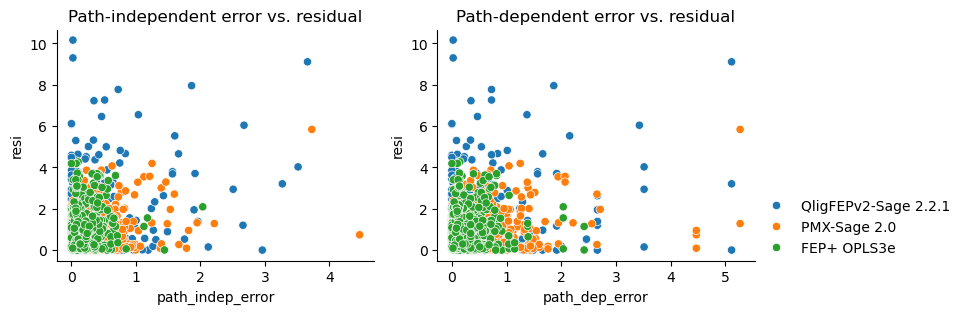

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3))

sns.scatterplot(
    data=all_dg_data.assign(resi=lambda x: (x["dg_value"] - x["sfc_dG"]).abs()),
    x="path_indep_error",
    y="resi",
    hue="value",
    ax=axs[0],
)

sns.scatterplot(
    data=all_dg_data.assign(resi=lambda x: (x["dg_value"] - x["sfc_dG"]).abs()),
    x="path_dep_error",
    y="resi",
    hue="value",
    ax=axs[1],
)
axs[0].set_title("Path-independent error vs. residual")
axs[0].legend_.remove()
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[1].set_title("Path-dependent error vs. residual")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].legend(bbox_to_anchor=(1.005, 0), loc="lower left", borderaxespad=0, frameon=False)

## Get metrics for $\Delta G$ values

In [61]:
qligfep_dG_metrics_df, qligfep_dG_verbose = get_metrics_df(
    qligfep_dG_dfs,
    ["KTAU", "RMSE", "MUE"],
    pred_col="sfc_dG",
    exp_col="dg_value",
    targets=qligfep_result_df.target.unique().tolist(),
    return_verbose=True,
    seed=42,
)

hahn_dG_metrics_df, hahn_dG_verbose = get_metrics_df(
    dHahn_dG_dfs.query("value == 'DDG_OpenFF-2.0'").dropna(),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="sfc_dG",
    exp_col="DG_Exp.",
    return_verbose=True,
    seed=42,
)

opls3e_dG_metrics_df, opls3e_dG_verbose = get_metrics_df(
    dHahn_dG_dfs.query("value == 'DDG_OPLS3e'").dropna(),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="sfc_dG",
    exp_col="DG_Exp.",
    return_verbose=True,
    seed=42,
)

In [62]:
metrics_dG_concat = pd.concat(
    [
        qligfep_dG_metrics_df.assign(method="QligFEP"),
        hahn_dG_metrics_df.assign(method="PMX-Sage 2.0"),
        opls3e_dG_metrics_df.assign(method="OPLS3e"),
    ]
).set_index("method", append=True)

metrics_dG_concat = metrics_dG_concat.unstack("method")
# print(metrics_dG_concat.to_markdown())

In [63]:
all_results = pd.concat(
    [
        qligfep_dG_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_dG_metrics_df.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_dG_metrics_df.assign(ForceField="FEP+ OPLS3e", order=3),
    ],
    ignore_index=False,
)

details_dG_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


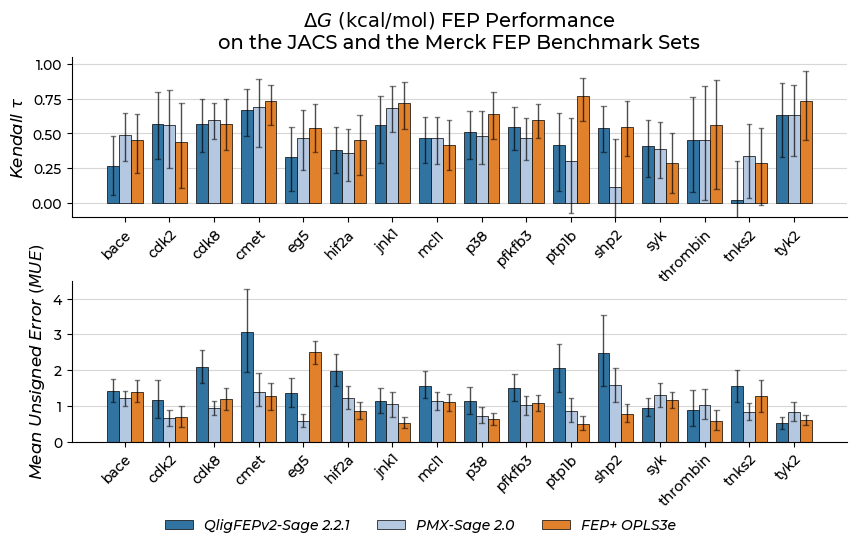

In [64]:
def plot_metrics_from_processed_FEP_df(
    df: pd.DataFrame,
    palette: str = "tab20",
    metrics=["KTAU", "MUE"],
    energy_type: Literal["dG", "ddG"] = "dG",
) -> tuple[plt.Figure, list[plt.Axes]]:
    fig, axs = plt.subplots(nrows=2, figsize=(10, 5))

    toplot_data = (
        df.reset_index(names=["target"])
        .assign(target_data=lambda x: x["target"] + " " + x["ForceField"])
        .sort_values(["target", "order"])
    )

    for ax, metric in zip(axs.flatten(), metrics):

        barplot = sns.barplot(
            toplot_data,
            hue="ForceField",
            x="target",
            y=f"{metric}_mean",
            ax=ax,
            palette=palette,
            edgecolor="black",
            linewidth=0.5,
        )

        # we use the error data because it has the correct order plotted by seaborn
        # 1st: plot all the values found in the `hue` column [0]
        # 2nd: plot all the values found in the `hue` column [1]
        # ...
        # We use order here because it represents the order where the `hue` values are found

        error_data = toplot_data.sort_values(["order", "target"])

        # idk why but barplot.patches contains all patches + 3 that are all equal to 0??
        # That's why we slice it
        data_patches = [p for p in barplot.patches if p.get_height() != 0 or p.get_width() != 0]

        # print(f"======== METRIC {metric} ========")
        for idx, bar in enumerate(data_patches):
            data_row = error_data.iloc[idx]

            if not np.isclose(bar.get_height(), data_row[f"{metric}_mean"]):
                print(f"Patch #{idx} height mismatch:")
                print(f"  - Bar Height (from plot):   {bar.get_height():.4f}")
                print(f"  - Data Value (from DF):     {data_row[f'{metric}_mean']:.4f}")
                print(f"  - Target {data_row['target']}; FF {data_row['ForceField']}")

            try:
                x_bar = bar.get_x() + bar.get_width() / 2
                # print(f"Processing Patch #{idx}:")
                # print(f"  - Bar Height (from plot):   {bar.get_height():.4f}")
                # print(f"  - Data Value (from DF):     {data_row[f'{metric}_mean']:.4f}")
                # print(f"  - Target {data_row['target']}; FF {data_row['ForceField']}")
            except IndexError:
                break

            y_start = data_row[f"{metric}_sub"]
            y_end = data_row[f"{metric}_sup"]
            # print(f"  - Lower Bound: {y_start:.4f}, Upper Bound: {y_end:.4f}")
            ax.vlines(x=x_bar, ymin=y_start, ymax=y_end, color="black", linewidth=1, alpha=0.7)
            cap_width = (
                0.1  # You can even make the cap width proportional to the bar width: bar.get_width() * 0.4
            )
            ax.plot(
                [x_bar - cap_width / 2, x_bar + cap_width / 2],
                [y_start, y_start],
                color="black",
                linewidth=1,
                alpha=0.5,
            )
            ax.plot(
                [x_bar - cap_width / 2, x_bar + cap_width / 2],
                [y_end, y_end],
                color="black",
                linewidth=1,
                alpha=0.5,
            )

        if metric == metrics[0]:
            if energy_type == "dG":
                ax.set_title(
                    r"$\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
                    "\non the JACS and the Merck FEP Benchmark Sets"
                )
            elif energy_type == "ddG":
                ax.set_title(
                    r"$\Delta\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
                    "\non the JACS and the Merck FEP Benchmark Sets"
                )

            # ax.set_title(
            #     "Analysis of Calculated $\Delta\Delta G (kcal/mol)$ Metrics for the JACS\nand the Merck FEP Benchmark Sets",
            # )
            # ax.legend(bbox_to_anchor=(1.02, -0.45), loc="lower left", borderaxespad=0, frameon=False)
            ax.set_ylabel(r"Kendall $\tau$")
            ax.legend().set_visible(False)
            ax.set_ylim(-0.1, 1.05)
        elif metric == "MUE":
            # ax.legend().set_visible(False)
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(0.45, -0.40),
                frameon=False,
                shadow=True,
                ncol=5,
            )
            ax.set_ylabel("Mean Unsigned Error $(MUE)$")
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            ha="right",
            rotation_mode="anchor",
            fontsize=10,
            family="monospace",
        )
        sns.despine(ax=ax, top=True, right=True)
        ax.set_xlabel("")
        ax.grid(axis="y", alpha=0.5)
        ax.set_axisbelow(True)
    # fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    return fig, axs


fig, axs = plot_metrics_from_processed_FEP_df(details_dG_df)
for idx, ax in enumerate(axs.flatten()):
    set_font_properties(ax)

fig.savefig("figures/dG_FEP_stacked-metrics.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/dG_FEP_stacked-metrics.png", bbox_inches="tight", dpi=300, facecolor="white")

## Residual analysis $\Delta\Delta G_{exp} - \Delta\Delta G_{calc}$

In [65]:
residuals_toplot = (
    pd.concat(
        [
            qligfep_result_df[["target", "fep_name", "residual"]].assign(ForceField="QligFEPv2-Sage 2.2.1"),
            hahn_results[["target", "edge", "OpenFF20_residual"]]
            .assign(
                fep_name=lambda x: x["edge"].str.replace("edge_", "FEP_"),
                ForceField="PMX-Sage 2.0",
            )
            .drop(columns=["edge"])
            .rename(columns={"OpenFF20_residual": "residual"}),
            hahn_results[["target", "edge", "OPLS3e_residual"]]
            .assign(fep_name=lambda x: x["edge"].str.replace("edge_", "FEP_"), ForceField="FEP+ OPLS3e")
            .drop(columns=["edge"])
            .rename(columns={"OPLS3e_residual": "residual"}),
        ]
    )
    .query("target.isin(@targets)")
    .reset_index()
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ptp1b_PMX-Sage 2.0 vs. ptp1b_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:8.231e-04 U_stat=1.644e+03
shp2_PMX-Sage 2.0 vs. shp2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:5.652e-04 U_stat=2.128e+03
shp2_QligFEPv2-Sage 2.2.1 vs. shp2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Holm-Bonferroni correction, P_val:2.570e-04 U_stat=1.479e+03
Statistics DataFrame with corrected p-values:
                                group1                       group2  \
0  cdk2 QligFEPv2-Sage 2.2.1, ($N=22$)  cdk2 PMX-Sage 2.0, ($N=25$)   
1          cdk2 PMX-Sage 2.0, ($N=25$)   cdk2 FEP+ OPLS3e, ($N=25$)   
2  jnk1 QligFEPv2-Sage 2.2.1, ($N=27$)  jnk1 PMX-Sage 2.0, ($N=31$)   
3          jnk1 PMX-Sage 2.0, ($N=31$)   jnk1

/tmp/ipykernel_1000812/1088077293.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


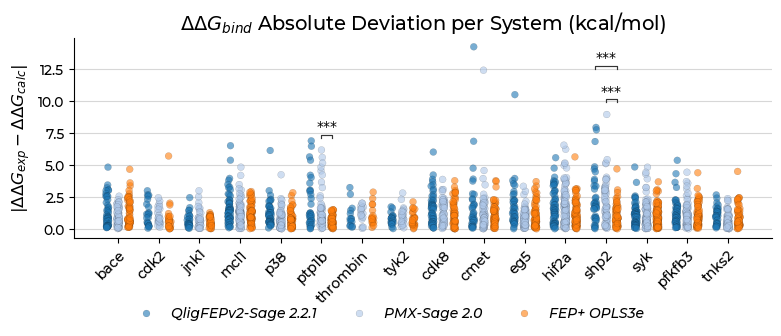

In [66]:
def get_significance_symbol(pvalue):
    """
      Converts a p-value to a significance symbol.

      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
    """
    if pvalue > 0.05:
        return "ns"
    elif pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    else:
        return ""


def get_corrected_pvalues_from_annotations(annotations, correction_method="holm"):
    """
    Extract corrected p-values from statannotations results.

    For Type 1 corrections (like Holm), we need to manually apply the correction
    to get the actual corrected p-values since they're not stored in the StatResult objects.
    """
    # Extract original p-values
    original_pvalues = [res.data.pvalue for res in annotations]

    # Type 1 corrections (Holm, BH, etc.) - need manual correction
    type1_methods = {
        "holm": "holm",
        "Holm-Bonferroni": "holm",
        "benjamini-hochberg": "fdr_bh",
        "BH": "fdr_bh",
        "Benjamini-Hochberg": "fdr_bh",
        "fdr_bh": "fdr_bh",
        "Benjamini-Yekutieli": "fdr_by",
        "BY": "fdr_by",
        "fdr_by": "fdr_by",
    }

    # Type 0 corrections (Bonferroni) - p-values are already corrected
    type0_methods = {"bonferroni": "bonferroni", "Bonferroni": "bonferroni"}

    if correction_method in type1_methods:
        # Apply correction manually to get corrected p-values
        statsmodels_method = type1_methods[correction_method]
        reject, corrected_pvalues, _, _ = multipletests(original_pvalues, method=statsmodels_method)
        return original_pvalues, corrected_pvalues

    elif correction_method in type0_methods:
        # P-values are already corrected in the StatResult objects
        corrected_pvalues = original_pvalues  # These are already corrected
        return None, corrected_pvalues  # Original p-values not available for Type 0

    else:
        # No correction or unknown method
        return original_pvalues, original_pvalues


fig, ax = plt.subplots(figsize=(9, 2.6))

absolute = True
palette = "tab20"

figure_kwargs = {
    "hue": "ForceField",
    "x": "target",
    "y": "residual",
    "ax": ax,
    "dodge": True,
}
data = (
    residuals_toplot.assign(residual=lambda x: x["residual"].abs()) if absolute else residuals_toplot
).copy()

stripplot = sns.stripplot(
    data,
    **{
        "palette": palette,
        "size": 5,
        "edgecolor": "black",
        "linewidth": 0.1,
        "alpha": 0.6,
    },
    **figure_kwargs,
)

configuration = {
    "test": "Mann-Whitney-gt",
    "comparisons_correction": "holm",
    "text_format": "star",
    "hide_non_significant": True,
    "line_width": 0.85,
    "line_height": 0.015,
}

# Prepare the pairs for the statistical test
forcefields = data.ForceField.unique().tolist()
ff_combinations = list(combinations(forcefields, 2))
sig_test_pairs = []
for target in targets:
    for combi in ff_combinations:
        sig_test_pairs.append(((target, combi[0]), (target, combi[1])))

# Plot the statistical test results
annotator = Annotator(data=data, pairs=sig_test_pairs, plot="stripplot", **figure_kwargs)
_, annotations = annotator.configure(**configuration).apply_and_annotate()

# Extract results with corrected p-values
stats_results = []
count_df = residuals_toplot.groupby("target").value_counts(["ForceField"])

# Get corrected p-values
original_pvals, corrected_pvals = get_corrected_pvalues_from_annotations(
    annotations, correction_method="holm"
)

for i, res in enumerate(annotations):
    stats_results.append(
        {
            "group1": f"{' '.join(res.data.group1)}, ($N={count_df[res.data.group1]}$)",
            "group2": f"{' '.join(res.data.group2)}, ($N={count_df[res.data.group2]}$)",
            "original_pvalue": original_pvals[i] if original_pvals else None,
            "corrected_pvalue": corrected_pvals[i],
            "pvalue": corrected_pvals[i],  # For backward compatibility
            "correction_method": "holm",
            "is_significant": res.data.corrected_significance,  # Use corrected significance
        }
    )

stats_df = pd.DataFrame(stats_results)

# Add significance symbols based on corrected p-values
stats_df = stats_df.assign(symbol=lambda x: x.corrected_pvalue.apply(get_significance_symbol))

# Now you have the corrected p-values and can use them as needed
print("Statistics DataFrame with corrected p-values:")
print(stats_df[["group1", "group2", "original_pvalue", "corrected_pvalue", "symbol"]].head())

# Pretyfy the plot :)
sns.despine(ax=ax, top=True, right=True)
ax.set_axisbelow(True)
ax.grid(axis="y", alpha=0.5)
ax.set_ylabel(r"$|\Delta\Delta G_{exp} - \Delta\Delta G_{calc}|$")
ax.set_xlabel("")
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=10, family="monospace"
)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, -0.28),
    frameon=False,
    shadow=True,
    ncol=3,
)
ax.set_title(
    r"$\Delta\Delta G_{bind}$ Absolute Deviation per System (kcal/mol)",
)
set_font_properties(ax)

fig.savefig("figures/stripplot-with-stats_ddG_deviation.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/stripplot-with-stats_ddG_deviation.png", bbox_inches="tight", dpi=300, facecolor="white")

In [67]:
stats_df.to_markdown("figures/ddG_deviation_stats.md", index=False)

# Plot metrics
Including bootstrapped confidence intervals for Kendall's tau, RMSE and MUE.

In [68]:
qligfep_ddG_metrics_df, qligfep_ddG_verbose = get_metrics_df(
    qligfep_result_df,
    ["KTAU", "RMSE", "MUE"],
    "Q_ddG_avg",
    "ddg_value",
    targets=qligfep_result_df.target.unique().tolist(),
    return_verbose=True,
    seed=42,
)

hahn_ddG_metrics_df, hahn_ddG_verbose = get_metrics_df(
    hahn_results,
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OpenFF-2.0",
    exp_col="DDG_Exp.",
    return_verbose=True,
    seed=42,
)

opls3e_ddG_metrics_df, opls3e_ddG_verbose = get_metrics_df(
    hahn_results.dropna(subset=["DDG_OPLS3e"]),
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OPLS3e",
    exp_col="DDG_Exp.",
    return_verbose=True,
    seed=42,
)

In [69]:
metrics_ddG_concat = pd.concat(
    [
        qligfep_ddG_metrics_df.assign(method="QligFEP"),
        hahn_ddG_metrics_df.assign(method="PMX-Sage 2.0"),
        opls3e_ddG_metrics_df.assign(method="OPLS3e"),
    ]
).set_index("method", append=True)

metrics_ddG_concat = metrics_ddG_concat.unstack("method")
# print(metrics_ddG_concat.to_markdown())

In [70]:
all_results = pd.concat(
    [
        qligfep_ddG_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_ddG_metrics_df.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_ddG_metrics_df.assign(ForceField="FEP+ OPLS3e", order=3),
    ],
    ignore_index=False,
)

details_ddG_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


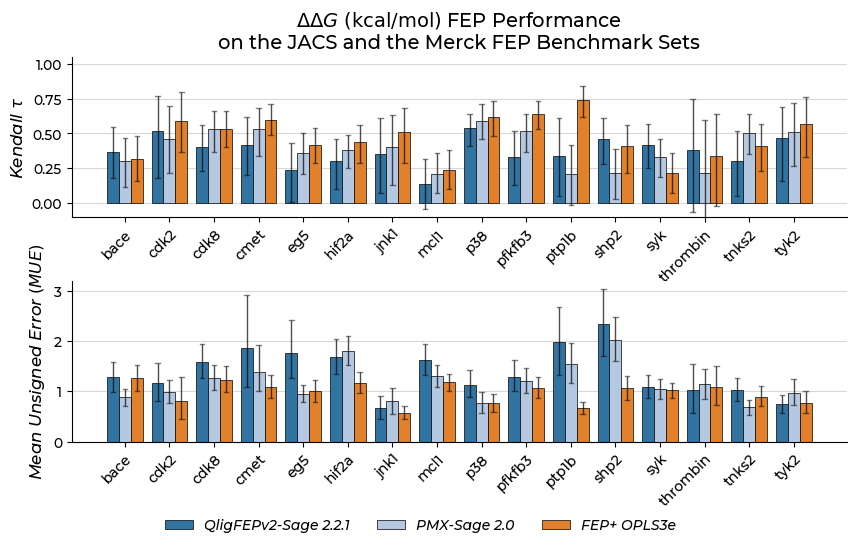

In [71]:
fig, axs = plot_metrics_from_processed_FEP_df(details_ddG_df, metrics=["KTAU", "MUE"], energy_type="ddG")
for ax in axs.flatten():
    set_font_properties(ax)
fig.savefig("figures/ddG_FEP_stacked-metrics.svg", bbox_inches="tight", facecolor="white")
fig.savefig("figures/ddG_FEP_stacked-metrics.png", bbox_inches="tight", dpi=300, facecolor="white")

# Statistical comparison of the performances

In [72]:
all_verbose_dG_results = pd.concat(
    [
        qligfep_dG_verbose.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_dG_verbose.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_dG_verbose.assign(ForceField="FEP+ OPLS3e", order=3),
    ],
    ignore_index=False,
)

all_verbose_ddG_results = pd.concat(
    [
        qligfep_ddG_verbose.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        hahn_ddG_verbose.assign(ForceField="PMX-Sage 2.0", order=2),
        opls3e_ddG_verbose.assign(ForceField="FEP+ OPLS3e", order=3),
    ],
    ignore_index=False,
)

In [73]:
def process_data_for_plotting(df: pd.DataFrame, statistic: str = "KTAU"):
    """
    Process the verbose results data to calculate summary statistics for bars.
    """
    # Filter for the specific statistic
    filtered_df = df[df["statistic"] == statistic].copy()

    # Calculate summary statistics
    summary_stats = (
        filtered_df.groupby(["target", "ForceField", "order"])["value"].agg([("mean", "mean")]).reset_index()
    )

    # Create column names consistent with your original code
    summary_stats[f"{statistic}_mean"] = summary_stats["mean"]

    return summary_stats


def plot_barplot_with_dots_and_stats(
    all_verbose_results: pd.DataFrame,
    metric_name: str = "KTAU",
    palette: str = "tab20",
    energy_type: Literal["dG", "ddG"] = "dG",
    statistical_test: str = "Mann-Whitney-gt",  # Paired t-test (parametric)
    correction_method: str = "holm",
    figsize: tuple = (9, 4),
    dot_size: float = 4,
    dot_alpha: float = 0.6,
):
    """
    Create a barplot with individual data points overlaid and statistical significance annotations.
    """

    # Process data for bars (means)
    dot_data = all_verbose_results[all_verbose_results["statistic"] == metric_name].copy()

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Overlay individual data points (dots)
    stripplot = sns.stripplot(
        data=dot_data,
        hue="ForceField",
        x="target",
        y="value",
        ax=ax,
        palette=palette,
        size=dot_size,
        edgecolor="black",
        linewidth=0.1,
        alpha=dot_alpha,
        dodge=True,
        jitter=True,
    )

    # Get unique targets and forcefields for statistical testing
    targets = dot_data["target"].unique()
    forcefields = dot_data["ForceField"].unique()
    ff_combinations = list(combinations(forcefields, 2))

    # Create pairs for statistical testing
    sig_test_pairs = []
    for target in targets:
        for combi in ff_combinations:
            sig_test_pairs.append(((target, combi[0]), (target, combi[1])))

    # Configure statistical testing
    configuration = {
        "test": statistical_test,
        "comparisons_correction": correction_method,
        "text_format": "star",
        "hide_non_significant": True,
        "line_width": 0.85,
        "line_height": 0.015,
        "loc": "inside",
    }

    figure_kwargs = {
        "hue": "ForceField",
        "x": "target",
        "y": "value",
        "ax": ax,
        "dodge": True,
    }

    # Apply statistical annotations
    try:
        # Note: We use the stripplot for annotations since it has the individual points
        annotator = Annotator(data=dot_data, pairs=sig_test_pairs, plot="stripplot", **figure_kwargs)
        _, annotations = annotator.configure(**configuration).apply_and_annotate()

        # Extract and process statistical results
        stats_results = []
        count_df = dot_data.groupby("target").value_counts(["ForceField"])

        # Get corrected p-values
        original_pvals, corrected_pvals = get_corrected_pvalues_from_annotations(
            annotations, correction_method=correction_method
        )

        for i, res in enumerate(annotations):
            stats_results.append(
                {
                    "group1": f"{' '.join(res.data.group1)}, (N={count_df[res.data.group1]})",
                    "group2": f"{' '.join(res.data.group2)}, (N={count_df[res.data.group2]})",
                    "original_pvalue": original_pvals[i] if original_pvals else None,
                    "corrected_pvalue": corrected_pvals[i],
                    "pvalue": corrected_pvals[i],
                    "correction_method": correction_method,
                    "is_significant": res.data.corrected_significance,
                }
            )

        stats_df = pd.DataFrame(stats_results)
        stats_df = stats_df.assign(symbol=lambda x: x.corrected_pvalue.apply(get_significance_symbol))

        print("Statistical Results Summary:")
        print(
            stats_df[["group1", "group2", "original_pvalue", "corrected_pvalue", "symbol"]].to_string(
                index=False
            )
        )

    except Exception as e:
        print(f"Statistical testing failed: {e}")
        stats_df = None

    # Customize plot appearance
    metric_string = metric_name if metric_name != "KTAU" else r"Kendall $\tau$"
    if energy_type == "dG":
        ax.set_title(
            rf"$\Delta G\ (\mathrm{{kcal/mol}})$ FEP Performance ({metric_string})"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )
    elif energy_type == "ddG":
        ax.set_title(
            rf"$\Delta\Delta G\ (\mathrm{{kcal/mol}})$ FEP Performance ({metric_string})"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )

    # Set appropriate y-label based on statistic
    if metric_name == "KTAU":
        ax.set_ylabel(r"Kendall $\tau$")
    elif metric_name == "MUE":
        ax.set_ylabel("Mean Unsigned Error (MUE)")
    else:
        ax.set_ylabel(metric_name)

    # Format plot
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=10,
        family="monospace",
    )

    sns.despine(ax=ax, top=True, right=True)
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

    # Remove duplicate legend (stripplot creates a second legend)
    handles, labels = ax.get_legend_handles_labels()
    # Keep only the first set of handles/labels (from barplot)
    n_forcefields = len(forcefields)
    ax.legend(
        handles[:n_forcefields],
        labels[:n_forcefields],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.28),
        frameon=False,
        shadow=True,
        ncol=n_forcefields,
    )

    plt.tight_layout()

    return fig, ax, stats_df if "stats_df" in locals() else None

In [74]:
def plot_combined_metrics_with_stats(
    details_df: pd.DataFrame,
    verbose_results_df: pd.DataFrame,
    metric_name: str = "KTAU",
    palette: str = "tab20",
    energy_type: Literal["dG", "ddG"] = "dG",
    statistical_test: str = "Mann-Whitney-gt",
    correction_method: str = "holm",
    figsize: tuple = (10, 5),
    dot_size: float = 3,
    dot_alpha: float = 0.5,
    show_error_bars: bool = True,
    show_dots: bool = True,
    show_stats: bool = True,
    ax: Optional[plt.Axes] = None,
) -> tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Create a combined plot with bar charts, error bars, individual data points, and statistical annotations.

    Parameters:
    -----------
    details_df : pd.DataFrame
        DataFrame with summary statistics and confidence intervals (from first method)
        Expected to have columns like 'KTAU_mean', 'KTAU_sub', 'KTAU_sup', etc.
    verbose_results_df : pd.DataFrame
        DataFrame with individual bootstrap samples (from second method)
        Expected to have columns: 'target', 'statistic', 'value', 'ForceField'
    metric_name : str
        The metric to plot (e.g., 'KTAU', 'MUE', 'RMSE')
    palette : str
        Color palette for the plot
    energy_type : Literal["dG", "ddG"]
        Type of energy calculation for title formatting
    statistical_test : str
        Statistical test to perform
    correction_method : str
        Multiple comparison correction method
    figsize : tuple
        Figure size (width, height)
    dot_size : float
        Size of individual data points
    dot_alpha : float
        Transparency of individual data points
    show_error_bars : bool
        Whether to show error bars from confidence intervals
    show_dots : bool
        Whether to show individual data points
    show_stats : bool
        Whether to perform statistical testing and show annotations

    Returns:
    --------
    tuple[plt.Figure, plt.Axes, pd.DataFrame]
        Figure, axes, and statistics results DataFrame
    """

    # Create figure
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.gcf()

    # Prepare data for bar plot (from details_df)
    toplot_data = (
        details_df.reset_index(names=["target"])
        .assign(target_data=lambda x: x["target"] + " " + x["ForceField"])
        .sort_values(["target", "order"])
    )

    verbose_results_df = verbose_results_df.sort_values(["target", "order"])

    # Create bar plot with means
    barplot = sns.barplot(
        data=toplot_data,
        hue="ForceField",
        x="target",
        y=f"{metric_name}_mean",
        ax=ax,
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
    )

    # Add error bars if requested
    if show_error_bars:
        # Sort error data to match seaborn's plotting order
        error_data = toplot_data.sort_values(["order", "target"])

        # Get data patches (excluding empty patches)
        data_patches = [p for p in barplot.patches if p.get_height() != 0 or p.get_width() != 0]

        # Add error bars
        for idx, bar in enumerate(data_patches):
            try:
                data_row = error_data.iloc[idx]
                x_bar = bar.get_x() + bar.get_width() / 2

                y_start = data_row[f"{metric_name}_sub"]
                y_end = data_row[f"{metric_name}_sup"]

                # Vertical line for error bar
                ax.vlines(x=x_bar, ymin=y_start, ymax=y_end, color="black", linewidth=1, alpha=0.7)

                # Caps for error bars
                cap_width = 0.1
                ax.plot(
                    [x_bar - cap_width / 2, x_bar + cap_width / 2],
                    [y_start, y_start],
                    color="black",
                    linewidth=1,
                    alpha=0.7,
                )
                ax.plot(
                    [x_bar - cap_width / 2, x_bar + cap_width / 2],
                    [y_end, y_end],
                    color="black",
                    linewidth=1,
                    alpha=0.7,
                )

            except IndexError:
                break

    # Overlay individual data points if requested
    if show_dots and verbose_results_df is not None:
        dot_data = verbose_results_df[verbose_results_df["statistic"] == metric_name].copy()

        if not dot_data.empty:
            # Add jittered points
            sns.stripplot(
                data=dot_data,
                hue="ForceField",
                x="target",
                y="value",
                ax=ax,
                palette=palette,
                size=dot_size,
                edgecolor="black",
                linewidth=0.1,
                alpha=dot_alpha,
                dodge=True,
                jitter=True,
                legend=False,  # Don't create duplicate legend
            )

    # Perform statistical testing if requested
    stats_df = None
    if show_stats and verbose_results_df is not None:
        dot_data = verbose_results_df[verbose_results_df["statistic"] == metric_name].copy()

        if not dot_data.empty:
            try:
                # Get unique targets and forcefields for statistical testing
                targets = dot_data["target"].unique()
                forcefields = dot_data["ForceField"].unique()
                ff_combinations = list(combinations(forcefields, 2))

                # Create pairs for statistical testing
                sig_test_pairs = []
                for target in targets:
                    for combi in ff_combinations:
                        sig_test_pairs.append(((target, combi[0]), (target, combi[1])))

                # Configure statistical testing
                configuration = {
                    "test": statistical_test,
                    "comparisons_correction": correction_method,
                    "text_format": "star",
                    "hide_non_significant": True,
                    "line_width": 0.85,
                    "line_height": 0.015,
                    "loc": "inside",
                }

                figure_kwargs = {
                    "hue": "ForceField",
                    "x": "target",
                    "y": "value",
                    "ax": ax,
                    "dodge": True,
                }

                # Apply statistical annotations
                annotator = Annotator(data=dot_data, pairs=sig_test_pairs, plot="stripplot", **figure_kwargs)
                _, annotations = annotator.configure(**configuration).apply_and_annotate()

                # Extract and process statistical results
                stats_results = []
                count_df = dot_data.groupby("target").value_counts(["ForceField"])

                # Get corrected p-values
                original_pvals, corrected_pvals = get_corrected_pvalues_from_annotations(
                    annotations, correction_method=correction_method
                )

                for i, res in enumerate(annotations):
                    stats_results.append(
                        {
                            "group1": f"{' '.join(res.data.group1)}, (N={count_df[res.data.group1]})",
                            "group2": f"{' '.join(res.data.group2)}, (N={count_df[res.data.group2]})",
                            "original_pvalue": original_pvals[i] if original_pvals else None,
                            "corrected_pvalue": corrected_pvals[i],
                            "pvalue": corrected_pvals[i],
                            "correction_method": correction_method,
                            "is_significant": res.data.corrected_significance,
                        }
                    )

                stats_df = pd.DataFrame(stats_results)
                if not stats_df.empty:
                    stats_df = stats_df.assign(
                        symbol=lambda x: x.corrected_pvalue.apply(get_significance_symbol)
                    )

                    print("Statistical Results Summary:")
                    print(
                        stats_df[
                            ["group1", "group2", "original_pvalue", "corrected_pvalue", "symbol"]
                        ].to_string(index=False)
                    )

            except Exception as e:
                print(f"Statistical testing failed: {e}")
                stats_df = None

    # Customize plot appearance
    metric_string = metric_name if metric_name != "KTAU" else r"Kendall $\tau$"
    if energy_type == "dG":
        ax.set_title(
            rf"$\Delta G\ (\mathrm{{kcal/mol}})$ FEP Performance ({metric_string})"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )
    elif energy_type == "ddG":
        ax.set_title(
            rf"$\Delta\Delta G\ (\mathrm{{kcal/mol}})$ FEP Performance ({metric_string})"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )

    # Set appropriate y-label based on statistic
    if metric_name == "KTAU":
        ax.set_ylabel(r"Kendall $\tau$")
        # if show_error_bars:
        #     ax.set_ylim(-0.1, 1.05)
    elif metric_name == "MUE":
        ax.set_ylabel("Mean Unsigned Error (MUE)")
    elif metric_name == "RMSE":
        ax.set_ylabel("Root Mean Square Error (RMSE)")
    else:
        ax.set_ylabel(metric_name)

    # Format plot
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=10,
        family="monospace",
    )

    sns.despine(ax=ax, top=True, right=True)
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

    # Handle legend - get unique forcefields from details_df
    unique_forcefields = toplot_data["ForceField"].unique()
    handles, labels = ax.get_legend_handles_labels()

    # Keep only the first set of handles/labels (from barplot)
    n_forcefields = len(unique_forcefields)
    ax.legend(
        handles[:n_forcefields],
        labels[:n_forcefields],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.3),
        frameon=False,
        shadow=True,
        ncol=n_forcefields,
    )

    plt.tight_layout()

    return fig, ax, stats_df

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cdk2_QligFEPv2-Sage 2.2.1 vs. cdk2_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:3.275e-14 U_stat=6.032e+05
bace_QligFEPv2-Sage 2.2.1 vs. bace_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:1.794e-41 U_stat=6.772e+05
ptp1b_QligFEPv2-Sage 2.2.1 vs. ptp1b_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:2.258e-90 U_stat=7.623e+05
shp2_QligFEPv2-Sage 2.2.1 vs. shp2_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:6.965e-295 U_stat=9.750e+05
syk_QligFEPv2-Sage 2.2.1 vs. syk_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:4.428e-114 U_stat=7.949e+05
syk_PMX-Sage 2.0 vs. syk_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Bon

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

eg5_PMX-Sage 2.0 vs. eg5_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:2.849e-29 U_stat=3.514e+05
hif2a_QligFEPv2-Sage 2.2.1 vs. hif2a_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:4.919e-56 U_stat=2.938e+05
jnk1_QligFEPv2-Sage 2.2.1 vs. jnk1_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:2.241e-108 U_stat=2.126e+05
bace_PMX-Sage 2.0 vs. bace_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:0.000e+00 U_stat=9.022e+03
thrombin_QligFEPv2-Sage 2.2.1 vs. thrombin_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:6.455e-36 U_stat=3.352e+05
tnks2_PMX-Sage 2.0 vs. tnks2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


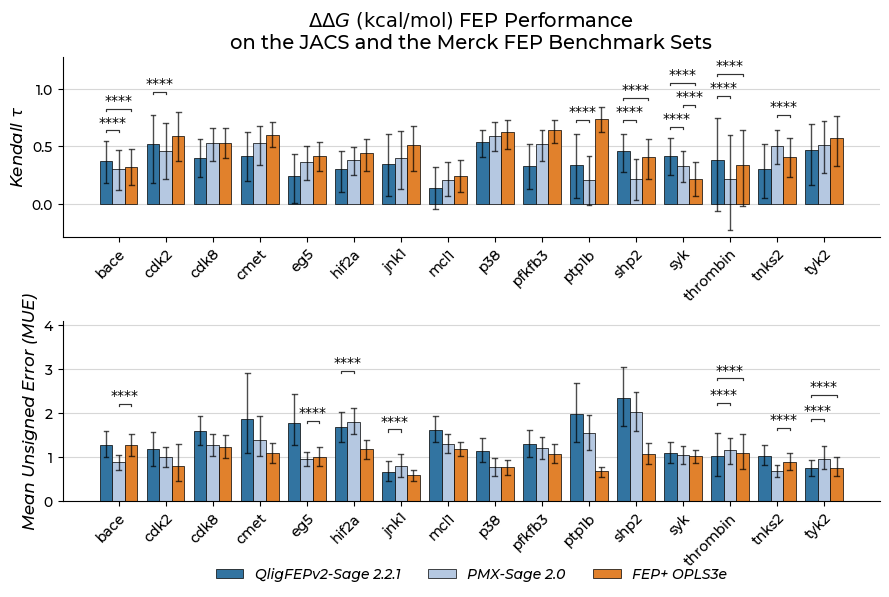

In [75]:
fig, axs = plt.subplots(nrows=2, figsize=(9, 6))
for idx, ax in enumerate(axs.flatten()):
    if idx == 0:
        fig, ax, stats_df = plot_combined_metrics_with_stats(
            details_df=details_ddG_df,
            verbose_results_df=all_verbose_ddG_results,
            metric_name="KTAU",
            statistical_test="Mann-Whitney-gt",
            correction_method="bonferroni",
            energy_type="ddG",
            show_error_bars=True,
            show_dots=False,
            show_stats=True,
            ax=ax,
        )
        ax.set_title(
            r"$\Delta\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )
        set_font_properties(ax)
        stats_df.to_markdown("figures/ddG_FEP_KTAU_stats.md", index=False)
        ax.legend().set_visible(False)
    elif idx == 1:
        fig, ax, stats_df = plot_combined_metrics_with_stats(
            details_df=details_ddG_df,
            verbose_results_df=all_verbose_ddG_results,
            metric_name="MUE",
            energy_type="ddG",
            statistical_test="Mann-Whitney-ls",
            correction_method="bonferroni",
            show_error_bars=True,
            show_dots=False,
            show_stats=True,
            ax=ax,
        )
        set_font_properties(ax)
        stats_df.to_markdown("figures/ddG_FEP_MUE_stats.md", index=False)
        ax.set_title("")

fig.savefig("figures/ddG_FEP_KTAU_MUE_with_stats.png", bbox_inches="tight", dpi=300, facecolor="white")
fig.savefig("figures/ddG_FEP_KTAU_MUE_with_stats.svg", bbox_inches="tight", facecolor="white")

fig.tight_layout()
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cdk2_PMX-Sage 2.0 vs. cdk2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:2.130e-17 U_stat=3.857e+05
eg5_PMX-Sage 2.0 vs. eg5_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:9.324e-178 U_stat=1.315e+05
hif2a_QligFEPv2-Sage 2.2.1 vs. hif2a_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:4.961e-98 U_stat=2.267e+05
jnk1_QligFEPv2-Sage 2.2.1 vs. jnk1_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:1.612e-154 U_stat=1.565e+05
bace_PMX-Sage 2.0 vs. bace_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:0.000e+00 U_stat=3.187e+03
syk_QligFEPv2-Sage 2.2.1 vs. syk_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


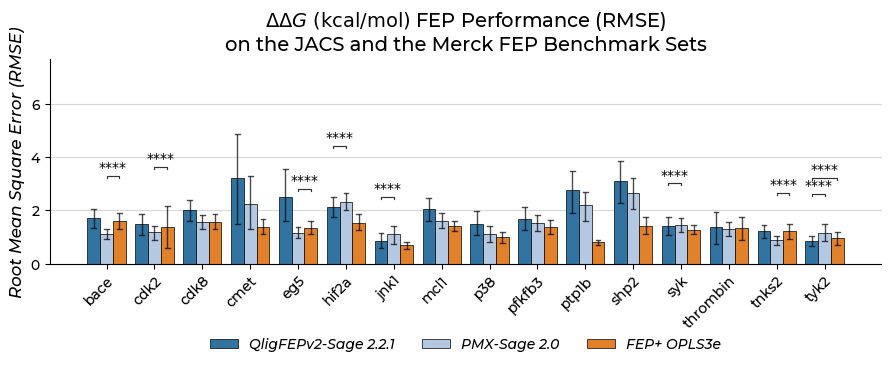

In [76]:
fig, ax, stats_df = plot_combined_metrics_with_stats(
    details_df=details_ddG_df,
    verbose_results_df=all_verbose_ddG_results,
    metric_name="RMSE",
    energy_type="ddG",
    statistical_test="Mann-Whitney-ls",
    correction_method="bonferroni",
    show_error_bars=True,
    show_dots=False,
    show_stats=True,
    figsize=(9, 4),
)
set_font_properties(ax)
stats_df.to_markdown("figures/ddG_FEP_RMSE_stats.md", index=False)
fig.savefig("figures/ddG_FEP_RMSE_with_stats.png", bbox_inches="tight", dpi=300, facecolor="white")
fig.savefig("figures/ddG_FEP_RMSE_with_stats.svg", bbox_inches="tight", facecolor="white")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cdk2_PMX-Sage 2.0 vs. cdk2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:2.241e-54 U_stat=7.031e+05
cdk8_PMX-Sage 2.0 vs. cdk8_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:8.445e-10 U_stat=5.855e+05
hif2a_QligFEPv2-Sage 2.2.1 vs. hif2a_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:1.492e-11 U_stat=5.929e+05
mcl1_PMX-Sage 2.0 vs. mcl1_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:4.067e-28 U_stat=6.456e+05
p38_QligFEPv2-Sage 2.2.1 vs. p38_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:6.364e-07 U_stat=5.718e+05
bace_PMX-Sage 2.0 vs. bace_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test greater with Bonferroni correction, P_val:4

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cdk8_PMX-Sage 2.0 vs. cdk8_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:9.843e-213 U_stat=9.671e+04
eg5_PMX-Sage 2.0 vs. eg5_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:0.000e+00 U_stat=0.000e+00
bace_PMX-Sage 2.0 vs. bace_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:2.770e-131 U_stat=1.835e+05
pfkfb3_PMX-Sage 2.0 vs. pfkfb3_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:5.251e-26 U_stat=3.600e+05
syk_QligFEPv2-Sage 2.2.1 vs. syk_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val:9.565e-265 U_stat=4.995e+04
thrombin_QligFEPv2-Sage 2.2.1 vs. thrombin_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Bonferroni correcti

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


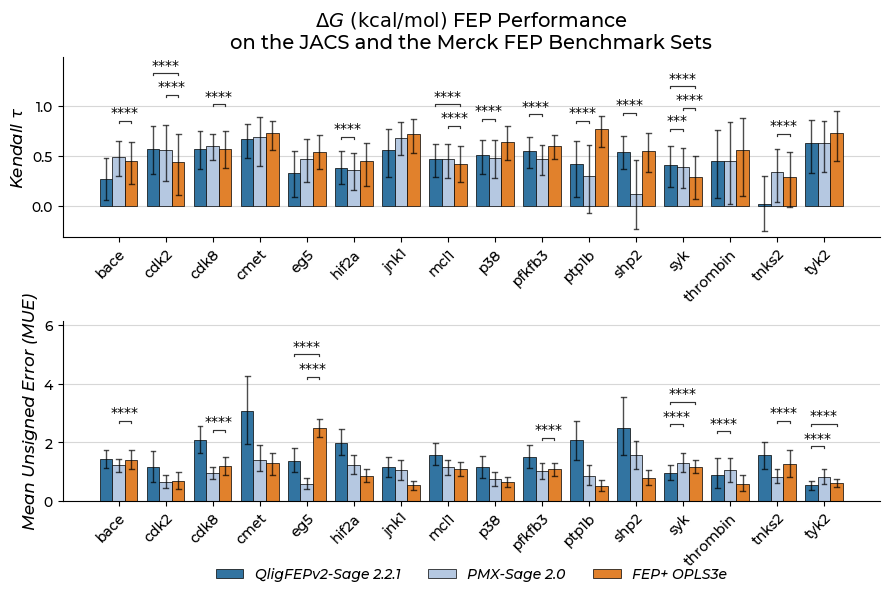

In [77]:
fig, axs = plt.subplots(nrows=2, figsize=(9, 6))
for idx, ax in enumerate(axs.flatten()):
    if idx == 0:
        fig, ax, stats_df = plot_combined_metrics_with_stats(
            details_df=details_dG_df,
            verbose_results_df=all_verbose_dG_results,
            metric_name="KTAU",
            statistical_test="Mann-Whitney-gt",
            correction_method="bonferroni",
            energy_type="dG",
            show_error_bars=True,
            show_dots=False,
            show_stats=True,
            ax=ax,
        )
        ax.set_title(
            r"$\Delta G\ (\mathrm{kcal/mol})$ FEP Performance"
            "\non the JACS and the Merck FEP Benchmark Sets"
        )
        set_font_properties(ax)
        stats_df.to_markdown("figures/dG_FEP_KTAU_stats.md", index=False)
        ax.legend().set_visible(False)
    elif idx == 1:
        fig, ax, stats_df = plot_combined_metrics_with_stats(
            details_df=details_dG_df,
            verbose_results_df=all_verbose_dG_results,
            metric_name="MUE",
            energy_type="dG",
            statistical_test="Mann-Whitney-ls",
            correction_method="bonferroni",
            show_error_bars=True,
            show_dots=False,
            show_stats=True,
            ax=ax,
        )
        set_font_properties(ax)
        stats_df.to_markdown("figures/dG_FEP_MUE_stats.md", index=False)
        ax.set_title("")

fig.savefig("figures/dG_FEP_KTAU_MUE_with_stats.png", bbox_inches="tight", dpi=300, facecolor="white")
fig.savefig("figures/dG_FEP_KTAU_MUE_with_stats.svg", bbox_inches="tight", facecolor="white")

fig.tight_layout()
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cdk2_PMX-Sage 2.0 vs. cdk2_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Holm-Bonferroni correction, P_val:2.671e-56 U_stat=2.964e+05
cdk8_PMX-Sage 2.0 vs. cdk8_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Holm-Bonferroni correction, P_val:1.020e-249 U_stat=6.443e+04
eg5_PMX-Sage 2.0 vs. eg5_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Holm-Bonferroni correction, P_val:0.000e+00 U_stat=0.000e+00
bace_PMX-Sage 2.0 vs. bace_FEP+ OPLS3e: Mann-Whitney-Wilcoxon test smaller with Holm-Bonferroni correction, P_val:1.599e-194 U_stat=1.161e+05
syk_QligFEPv2-Sage 2.2.1 vs. syk_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller with Holm-Bonferroni correction, P_val:5.345e-252 U_stat=6.242e+04
thrombin_QligFEPv2-Sage 2.2.1 vs. thrombin_PMX-Sage 2.0: Mann-Whitney-Wilcoxon test smaller wit

/tmp/ipykernel_1000812/4194060380.py:252: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


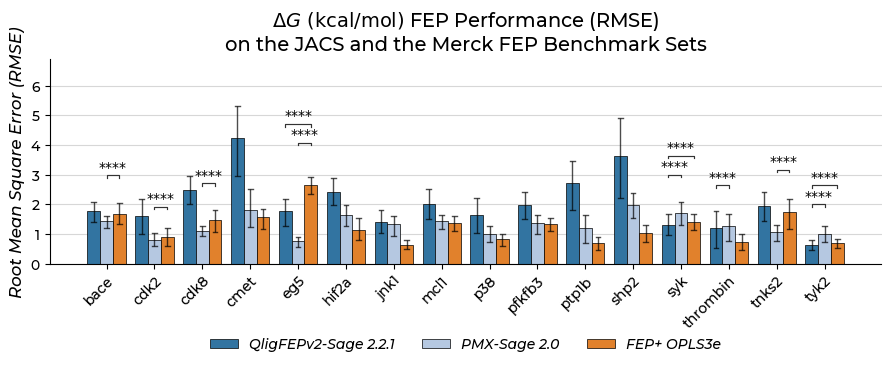

In [78]:
fig, ax, stats_df = plot_combined_metrics_with_stats(
    details_df=details_dG_df,
    verbose_results_df=all_verbose_dG_results,
    metric_name="RMSE",
    energy_type="dG",
    statistical_test="Mann-Whitney-ls",
    show_error_bars=True,
    show_dots=False,
    show_stats=True,
    figsize=(9, 4),
)
set_font_properties(ax)
stats_df.to_markdown("figures/dG_FEP_RMSE_stats.md", index=False)
fig.savefig("figures/dG_FEP_RMSE_with_stats.png", bbox_inches="tight", dpi=300, facecolor="white")
fig.savefig("figures/dG_FEP_RMSE_with_stats.svg", bbox_inches="tight", facecolor="white")

# Supplementary
Plotting the results including QmapFEP

In [80]:
openff2_qmapfep = pd.read_csv("supplementary/supplementary_openff2-0-0_QmapFEP.csv")
opls_qmapfep = pd.read_csv("supplementary/supplementary_opls2015_QmapFEP.csv")

qmapfep_openff2_metrics_df, _ = get_metrics_df(
    openff2_qmapfep,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
    return_verbose=False,
    seed=42,
)

qmapfep_opls_metrics_df, _ = get_metrics_df(
    opls_qmapfep,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
    return_verbose=False,
    seed=42,
)

In [81]:
all_results = pd.concat(
    [
        qligfep_ddG_metrics_df.assign(ForceField="QligFEPv2-Sage 2.2.1", order=1),
        qmapfep_openff2_metrics_df.assign(ForceField="QmapFEP-OpenFF 2.0", order=2),
        qmapfep_opls_metrics_df.assign(ForceField="QmapFEP-OPLS-AA 2015", order=3),
        hahn_ddG_metrics_df.assign(ForceField="PMX-Sage 2.0", order=4),
        opls3e_ddG_metrics_df.assign(ForceField="FEP+ OPLS3e", order=5),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1000812/4148435529.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


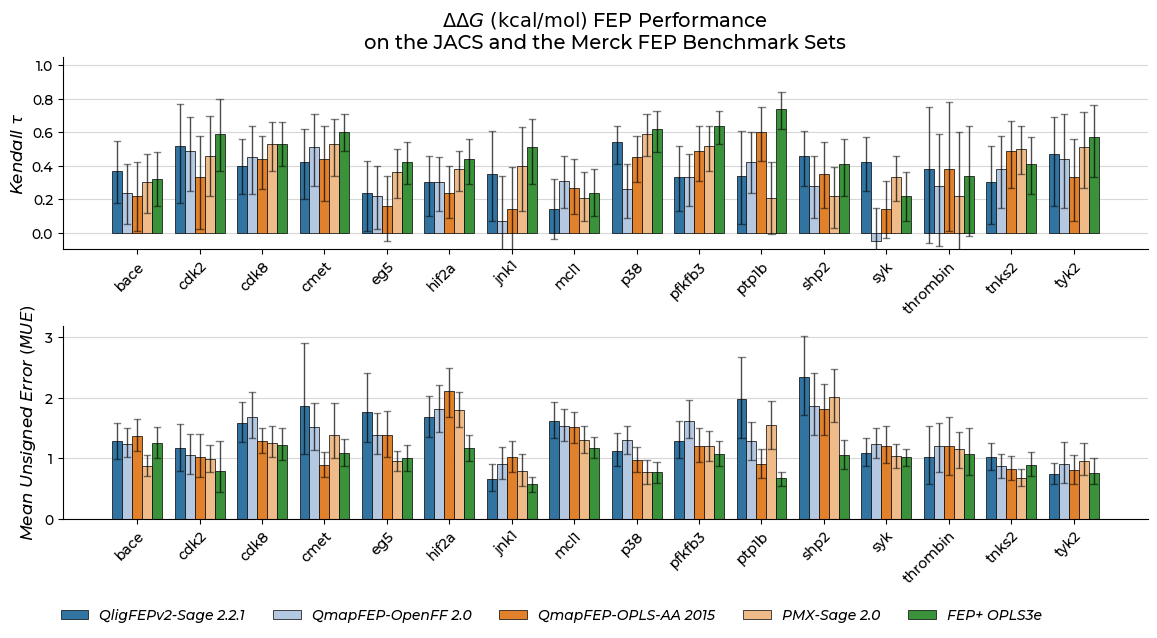

In [82]:
fig, axs = plot_metrics_from_processed_FEP_df(details_df, metrics=["KTAU", "MUE"], energy_type="ddG")
for ax in axs.flatten():
    set_font_properties(ax)
fig.set_size_inches(14, 6)

In [85]:
print("$\Delta\Delta G$ Performance metrics:\n")
print(metrics_ddG_concat.to_markdown())
print("$\Delta G$ Performance metrics:\n")
print(metrics_dG_concat.to_markdown())

$\Delta\Delta G$ Performance metrics:

|          | ('KTAU', 'OPLS3e')    | ('KTAU', 'PMX-Sage 2.0')   | ('KTAU', 'QligFEP')   | ('RMSE', 'OPLS3e')   | ('RMSE', 'PMX-Sage 2.0')   | ('RMSE', 'QligFEP')   | ('MUE', 'OPLS3e')    | ('MUE', 'PMX-Sage 2.0')   | ('MUE', 'QligFEP')   |   ('N', 'OPLS3e') |   ('N', 'PMX-Sage 2.0') |   ('N', 'QligFEP') |
|:---------|:----------------------|:---------------------------|:----------------------|:---------------------|:---------------------------|:----------------------|:---------------------|:--------------------------|:---------------------|------------------:|------------------------:|-------------------:|
| bace     | $0.32_{0.16}^{0.48}$  | $0.3_{0.12}^{0.47}$        | $0.37_{0.18}^{0.55}$  | $1.61_{1.31}^{1.91}$ | $1.1_{0.92}^{1.28}$        | $1.7_{1.35}^{2.05}$   | $1.26_{1.01}^{1.52}$ | $0.88_{0.71}^{1.05}$      | $1.28_{0.99}^{1.59}$ |                58 |                      58 |                 49 |
| cdk2     | $0.59_{0.37}^{0.8}$   | $0.